# Analiza zależności między częstotliwością walk w MMA a rezultatami

## Segment 1: *Wprowadzenie*

Celem analizy jest ustalenie, czy istnieje znacząca statystycznie zależność między długością interwałów czasowych pomiędzy toczonymi walkami w MMA a ich rezultatem, przy użyciu statystyki opisowej. **Rezultat w analizie definiowany jest** jako stosunek procentowy pomiędzy ilością zwycięstw a sumą zwycięstw i przegranych dla danego zawodnika (z założenia współczynnik **nie będzie uwzględniać** walk zakończonych remisami lub uznanych za no-contest).

Statystycznie znaczącą zależność w analizie definiowana będzie jako 10 punktów procentowych. Analiza nie pominie jednak zależności poniżej tego progu, jeśli zgromadzone dane pozwolą na postawienie racjonalnej hipotezy. 

Analiza obejmować będzie wszystkie **zawodowe** walki zarejestrowane za pośrednictwem serwisu www.sherdog.com. 

W celu zbadania potencjalnego istnienia zależności charakterystycznych dla konkretnych grup analiza uwzględni następujące kategorie: 

* aktualny roster UFC
* aktualny roster UFC z uwzględnieniem walk stoczonych tylko dla federacji UFC
* aktualny roster UFC z uwzględnieniem walk stoczonych tylko dla federacji UFC (podział na płeć)
* aktualny roster UFC z uwzględnieniem walk stoczonych tylko dla federacji UFC (podział na kategorie wagowe)
* cała baza zawodnicza Sherdoga z uwzględnieniem przypadków, w których zawodnik swoją poprzednią walkę przegrał przez KO/TKO
* aktualny roster UFC z uwzględnieniem przypadków, w których zawodnik swoją poprzednią walkę przegrał przez KO/TKO
* cała baza zawodnicza z uwzględnieniem przypadków, w których zawodnik swoją poprzednią walkę zawodnik stoczył na dystansie mistrzowskim (5 rund)
* dla rosteru UFC z uwzględnieniem przypadków, w których zawodnik swoją poprzednią walkę stoczył na dystansie mistrzowskim (5 rund)

Dodatkowo przedstawione zostaną – jako produkt uboczny powyższej analizy – następujące ciekawostki:

* interwał z największą liczbą odnotowanych obserwacji dla poszczególnych kategorii wagowych w UFC
* zależność pomiędzy rezultatem dla wszystkich zawodników w MMA (baza sherdoga) a rezultatem aktualnego rostera UFC
* procent zawodników aktualnego rostera UFC, który wygrał swój debiut w MMA
* który z zawodników w historii MMA miał najdłuższą przerwę pomiędzy stoczonymi walkami i ile dni ona wyniosła

## Segment 2: *Wczytanie, oczyszczenie i analiza danych dla całej bazy zawodniczej*

In [328]:
# Import niezbędnych bibliotek

import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import os
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [330]:
# Wczytanie danych dla całej bazy zawodniczej
sherdog_data = pd.read_csv('sherdog_final.csv', header=0, sep=";", engine='python')
sherdog_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time;
0,Tony Galindo,Tony Lopez,loss,KOTC 49 Soboba,Mar / 20 / 2005,KO (Punches),NaN,1,3:24;
1,Tony Galindo,Joey Villasenor,loss,KOTC 21 Invasion,Feb / 21 / 2003,TKO (Corner Stoppage),Larry Landless,1,5:00;
2,Tony Galindo,Brian Sleeman,loss,GC 6 Caged Beasts,Sep / 09 / 2001,TKO (Corner Stoppage),Larry Landless,2,3:10;
3,Tony Galindo,Reggie Cardiel,win,KOTC 9 Showtime,Jun / 23 / 2001,Decision,NaN,2,5:00;
4,Tony Galindo,Reggie Cardiel,draw,KOTC 7 Wet and Wild,Feb / 24 / 2001,Draw,NaN,2,5:00;
5,Tony Galindo,Brian Hawkins,win,KOTC 6 Road Warriors,Nov / 29 / 2000,TKO (Punches),NaN,1,1:30;
6,Tony Galindo,Kurt Rojo,win,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
7,Kurt Rojo,Phillip Miller,loss,GC 1 Gladiator Challenge 1,Dec / 09 / 2000,Decision,NaN,3,5:00;
8,Kurt Rojo,Tony Galindo,loss,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
9,Brian Hawkins,James Lee,loss,KOTC Drop Zone,Mar / 18 / 2006,Submission (Heel Hook),NaN,1,0:24;


In [331]:
# Utworzenie kopii obiektu DataFrame z ograniczeniem do interesujących nas kolumn.
sherdog_selected_data = sherdog_data[['Fighter', 'Result', 'Event_date']].copy()

In [332]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date
0,Tony Galindo,loss,Mar / 20 / 2005
1,Tony Galindo,loss,Feb / 21 / 2003
2,Tony Galindo,loss,Sep / 09 / 2001
3,Tony Galindo,win,Jun / 23 / 2001
4,Tony Galindo,draw,Feb / 24 / 2001
5,Tony Galindo,win,Nov / 29 / 2000
6,Tony Galindo,win,Jun / 24 / 2000
7,Kurt Rojo,loss,Dec / 09 / 2000
8,Kurt Rojo,loss,Jun / 24 / 2000
9,Brian Hawkins,loss,Mar / 18 / 2006


In [333]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z datą eventu.
sherdog_selected_data[sherdog_selected_data['Event_date'].isna()]

,Fighter,Result,Event_date


In [334]:
# Konwersja danych w tabeli Event_date z zapisu w formie string do zunifikowanego formatu daty.
converted_dates = []
for i in range(len(sherdog_selected_data['Event_date'])):
    converted_dates.append(parse(sherdog_selected_data['Event_date'][i]))

In [335]:
# Przypisanie skonwertowanych dat do tabeli Event_date.
sherdog_selected_data['Event_date'] = converted_dates

In [336]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date
0,Tony Galindo,loss,2005-03-20
1,Tony Galindo,loss,2003-02-21
2,Tony Galindo,loss,2001-09-09
3,Tony Galindo,win,2001-06-23
4,Tony Galindo,draw,2001-02-24
5,Tony Galindo,win,2000-11-29
6,Tony Galindo,win,2000-06-24
7,Kurt Rojo,loss,2000-12-09
8,Kurt Rojo,loss,2000-06-24
9,Brian Hawkins,loss,2006-03-18


In [337]:
# Utworzenie interwałów czasowych pomiędzy walkami dla każdego z zawodników.
intervals = []
for i in range(len(sherdog_selected_data['Fighter']) - 1):
    if sherdog_selected_data['Fighter'][i] == sherdog_selected_data['Fighter'][i + 1]:
        intervals.append(sherdog_selected_data['Event_date'][i] - sherdog_selected_data['Event_date'][i + 1])
        intervals[i] = intervals[i].days
    else:
        intervals.append(0)
intervals.append(0)   # ostatni interwał czasowy dla ostatniego zawodnika w bazie danych wynosił będzie 0.

In [338]:
# Przypisanie utworzonych interwałów do nowej kolumny w tabeli.
sherdog_selected_data['Time_interval'] = intervals

In [339]:
# Sprawdzenie poprawości danych - wszystkie interwały powinny być większe lub równe 0.
'''Jeden błędny rekord spowodowany brakiem prawidłowej daty debiutu tego zawodnika w bazie sherdoga - 
rekord zostanie pominięty w dalszej analizie.'''
sherdog_selected_data[sherdog_selected_data['Time_interval'] < 0]

,Fighter,Result,Event_date,Time_interval
25590,Paulo de Jesus,loss,1995-07-05,-2340


In [340]:
# Odrzucenie powyższego rekordu.
sherdog_selected_data = sherdog_selected_data.drop(sherdog_selected_data.index[25590])

In [341]:
# Przyjrzenie się dystrybucji danych przed przystąpieniem do właściwej analizy.
sherdog_selected_data.describe()

,Time_interval
count,504347.000000
mean,162.577224
std,293.667982
min,0.000000
25%,0.000000
50%,77.000000
75%,189.000000
max,8730.000000


In [342]:
# Przypisanie średniej, mediany i dominanty do zmiennych.
sher_mean = sherdog_selected_data['Time_interval'].mean()
sher_med = sherdog_selected_data['Time_interval'].median()
sher_mode = sherdog_selected_data['Time_interval'].mode().get_values() + 5   # Przesunięcie dominanty na potrzeby wizualizacji.
                                                                                

In [343]:
# Sprawdzenie ilości interwałów czasowych.
len(sherdog_selected_data['Time_interval'].value_counts())

2947

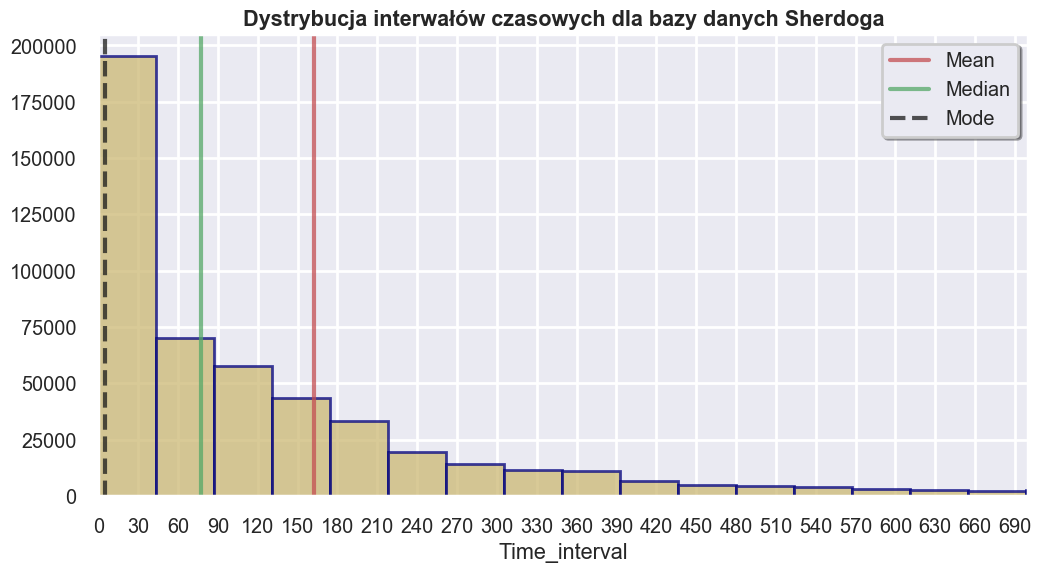

In [344]:
# Wizualizacja dystrybucji.
plt.rcdefaults()
    
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.distplot(sherdog_selected_data['Time_interval'], kde=False, color='y', bins=200,
                  hist_kws=dict(edgecolor='navy', alpha=0.75))
ax.set_xlim(0, 700)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

ax.axvline(sher_mean, color='r', linestyle='solid', alpha=0.75)
ax.axvline(sher_med, color='g', linestyle='solid', alpha=0.75)
ax.axvline(sher_mode, color='k', linestyle='dashed', alpha=0.75)
plt.title('Dystrybucja interwałów czasowych dla bazy danych Sherdoga', fontweight='bold')
plt.legend({'Mean':sher_mean, 'Median':sher_med, 'Mode':sher_mode}, frameon=True, shadow=True)
plt.show()

In [345]:
# Wyliczenie piętnastu najczęściej występujących interwałów czasowych w zbiorze danych.
sherdog_selected_data['Time_interval'].value_counts().nlargest(15)

0      138034
63       6804
56       6385
91       6185
70       6066
28       6003
35       5913
84       5789
49       5756
77       5713
42       5529
98       5367
105      5138
119      5025
21       4858
Name: Time_interval, dtype: int64

In [346]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval
0,Tony Galindo,loss,2005-03-20,758
1,Tony Galindo,loss,2003-02-21,530
2,Tony Galindo,loss,2001-09-09,78
3,Tony Galindo,win,2001-06-23,119
4,Tony Galindo,draw,2001-02-24,87
5,Tony Galindo,win,2000-11-29,158
6,Tony Galindo,win,2000-06-24,0
7,Kurt Rojo,loss,2000-12-09,168
8,Kurt Rojo,loss,2000-06-24,0
9,Brian Hawkins,loss,2006-03-18,1121


Jak widzimy na powyższym wykresie, dystrybucja interwałów, które wyliczone zostały w dniach, jest silnie asymetryczna (pozytywnie). Mamy do czynienia z ***2947 różnymi interwałami.*** Biorąc pod uwagę asymetrię rozkładu, liczbę interwałów, fakt, że mamy do czynienia z danymi dotyczącymi całej populacji oraz praktyczną (z punktu widzenia analizy walk MMA) potrzebę skategoryzowania tychże interwałów w czytelnej i dającej się przeanalizować formie, decydujemy się na uformowanie koszyków (kategorii), które posłużą nam w dalszej analizie:

* Koszyk nr 1 - Debiut/walka stoczona tego samego dnia *(0 dni)*
* Koszyk nr 2 - Bardzo często *(1-90 dni)*
* Koszyk nr 3 - Często *(91 - 120 dni)*
* Koszyk nr 4 - Umiarkowanie często *(121 - 182 dni)*
* Koszyk nr 5 - Rzadko *(183 - 365 dni)*
* Koszyk nr 6 - Bardzo rzadko *(366 dni - 728 dni)*
* Koszyk nr 7 - Powrót po bardzo długiej przerwie *(powyżej 729 dni)*

**Pierwszy koszyk** uwzględnia debiut zawodowy oraz walki stoczone w ramach 1-dniowych turniejów, które były domeną japośnkiej sceny MMA.

**Koszyk numer dwa** zakłada, że zawodnik z taką częstotliwością walczyłby mniej więcej 4 razy w skali roku, co jak na obecne standardy czołowych organizacji (nawet wziąwszy pod uwagę ilość gal, które produkuje UFC) jest raczej rzadkim zjawiskiem. 

**Koszyk numer trzy** zakłada, że zawodnik przy takiej częstotliwości walczyłby około 3 razy w skali roku, co jak na obecne standardy UFC jest możliwie, jednak relatywnie rzadkie i zasadnym jest nadać temu koszykowi etykietę dużej częstotliwości.

**Koszyk numer cztery** zakłada, że zawodnik przy takiej częstotliwości walczyłby około 2 razy w skali roku, co ze względu na plany zawodników obecnego rosteru UFC wydaje się planem minimum, jaki zawodnicy sobie na dany rok stawiają - oczywiście plan ten nie uwzględnia czynników zewnętrznych i losowych takich jak potencjalne naruszenie polityki antydopingowej, kontuzje, czy powody osobiste, w świetle których zawodnik zmuszony jest zrezygnować z przyjęcia walki. 2 walki w skali roku wydają się również zbiegać z zapotrzebowaniem UFC, które w 2019 zobligowało się do zorganizowania 43 eventów. Jeśli wziąć pod uwagę, że na każdym z nich jest 11-12 pojedynków, to mamy w przybliżeniu 1032 zawodników w skali roku do wypełnienia wszystkich eventów. Obecny roster UFC liczy sobie 698 atletów (*według www.UFC.com, stan na 12.11.2019 r.*), więc racjonalnym wydaje się przyjęcie tutaj założenia, że częstotliwość dwóch walk w skali roku jest złotym standardem, który najlepiej współgra z terminarzem czołowej organizacji MMA na świecie.

**Koszyk numer pięć** zakłada, że zawodnik walczy relatywnie rzadko i przy tej częstotliwości toczy walkę mniej więcej raz do roku. Warto tutaj zaznaczyć, że ta częstotliwość również współgra z planami terminarzowymi UFC i jest planem minimum, ale nie anomalią. Należy mieć na uwadze, że taka częstotliwość w przypadku zawodników, którzy na wczesnych etapach kariery walczyli w mniejszych organizacjach, nie oznacza tego samego, co dla walk w UFC - jedna walka w roku dla zawodnika, który próbuje wyrobić sobie nazwisko i dostać się do czołowych organizacji MMA, możemy rozpatrywać w kategorii - rzadko.

**Koszyk numer sześć** zakłada, że zawodnik walczy bardzo rzadko i jego walki odbywają się z częstotliwością niższą niż 1 walka do roku, ale nie wyższą niż 1 walka na 2 lata.

**Koszyk numer siedem** opisuje przypadki, w których zawodnik wracał do MMA po bardzo długiej przerwie (ponad 2 lata).

In [347]:
# Przygotowanie koszyków oraz etykiet dla grup i przypisanie ich do zmiennej cats.
bins = [0, 1, 91, 121, 183, 366, 729, 10000]
group_names = ['Debiut/walka stoczona tego samego dnia', 
               'Bardzo często (~4 walki w skali roku)', 
               'Często (~3 walki w skali roku)', 
               'Umiarkowanie często (~2 walki w skali roku)', 
               'Rzadko (~1 walka w skali roku)', 
               'Bardzo rzadko (rzadziej niż 1 raz do roku)',
               'Powrót po bardzo długiej przerwie (powyżej 2 lat)']
cats = pd.cut(sherdog_selected_data['Time_interval'], bins, labels=group_names, right=False)

In [348]:
# Dodanie kolumny z opisowy interwałem czasowym.
sherdog_selected_data['Descriptive_interval'] = cats

In [349]:
sherdog_selected_data[0:20]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Tony Galindo,loss,2005-03-20,758,Powrót po bardzo długiej przerwie (powyżej 2 lat)
1,Tony Galindo,loss,2003-02-21,530,Bardzo rzadko (rzadziej niż 1 raz do roku)
2,Tony Galindo,loss,2001-09-09,78,Bardzo często (~4 walki w skali roku)
3,Tony Galindo,win,2001-06-23,119,Często (~3 walki w skali roku)
4,Tony Galindo,draw,2001-02-24,87,Bardzo często (~4 walki w skali roku)
5,Tony Galindo,win,2000-11-29,158,Umiarkowanie często (~2 walki w skali roku)
6,Tony Galindo,win,2000-06-24,0,Debiut/walka stoczona tego samego dnia
7,Kurt Rojo,loss,2000-12-09,168,Umiarkowanie często (~2 walki w skali roku)
8,Kurt Rojo,loss,2000-06-24,0,Debiut/walka stoczona tego samego dnia
9,Brian Hawkins,loss,2006-03-18,1121,Powrót po bardzo długiej przerwie (powyżej 2 lat)


In [350]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej.
sherdog_brackets = sherdog_selected_data['Descriptive_interval']

In [351]:
# Utworzenie zmiennych, gdzie przechowywana będzie sumaryczna ilość walk dla poszczególnych kryteriów.
all_fights_count = sherdog_brackets.value_counts()
win_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'win'].value_counts()
loss_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'loss'].value_counts()
draw_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'draw'].value_counts()
nc_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'NC'].value_counts()

In [352]:
# Suma wszystkich walk w bazie zawodniczej.
all_fights_count.sum()

504347

In [353]:
# Suma wszystkich walk w bazie zawodniczej zakończonych wygraną.
win_fights_count.sum()

246434

In [354]:
# Suma wszystkich walk w bazie zawodniczej zakończonych przegraną.
loss_fights_count.sum()

246343

In [355]:
# Suma wszystkich walk w bazie zawodniczej zakończonych remisem.
draw_fights_count.sum()

8702

In [356]:
# Suma wszystkich walk w bazie zawodniczej zakończonych jako no-contest.
nc_fights_count.sum()

2868

In [357]:
# Weryfikacja, czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii.
sum_of_brackets = win_fights_count.sum() + loss_fights_count.sum() + draw_fights_count.sum() + nc_fights_count.sum()
if all_fights_count.sum() == sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [358]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
sherdog_pct = win_fights_count/(win_fights_count + loss_fights_count)

In [359]:
# Posortowanie wyników w kolejności malejącej.
sherdog_pct_sorted = sherdog_pct.sort_values(ascending=False)

In [360]:
# Konwersja ułamków na liczby dające się przedstawić w %.
sherdog_true_pct = sherdog_pct * 100

In [361]:
sherdog_pct_sorted

Często (~3 walki w skali roku)                       0.553287
Umiarkowanie często (~2 walki w skali roku)          0.542192
Bardzo często (~4 walki w skali roku)                0.539734
Rzadko (~1 walka w skali roku)                       0.521535
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.490557
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.454122
Debiut/walka stoczona tego samego dnia               0.424212
Name: Descriptive_interval, dtype: float64

Najwyższy współczynnik zwycięstw przypadł grupie, która swoje walki toczyła często, a przedział czasowy między walkami wyniósł od 91 do 120 dni. Warto zauważyć, że różnice pomiędzy czterema grupami z najwyższym wynikiem są relatywnie małe (nie przekraczają *2 punktów procentowych*). 

Bardziej drastyczny spadek następuje dopiero przy grupie, która walczyła rzadziej niż raz do roku i tutaj współczynnik procentowy spada poniżej status quo, czyli *50%*. Kolejny jeszcze bardziej zauważalny przeskok, bo niemal o *4 punkty procentowe* widzimy przy grupie, która do walk wróciła po długiej rozłące i rezultat dla tej grupy wyniósł nieco ponad *45%*. 

Grupa z najniższym współczynnikiem to debiutanci i uczestnicy 1-dniowych turniejów - tutaj wynik jest zauważalnie niższy (ponad *13 punktów procentowych* różnicy pomiędzy tą grupą a koszykiem z najlepszym rezultatem). Warto jednak mieć na uwadze, że sam fakt braku doświadczenia zawodnika w przypadku debiutu powinien znacząco obniżać jego szanse na zwycięstwo (nie możemy wykluczyć, że wiele z tych walk debiutanci stoczyli z zawodnikami, którzy mieli już doświadczenie w startach). 

**Wnioski:**
* nie odnotowano znaczących statystycznie różnic pomiędzy grupami, które walczyły od 1 do 4 walk w skali roku
* odnotowano zauważalną różnicę wynoszącą ponad 6 punktów procentowych pomiędzy grupą walczącą często a tą, która swoje walki toczyła rzadziej niż raz do roku
* odnotowano statystycznie istotną różnicę niecałych 10 punktów procentowych pomiędzy grupą walczącą często a zawodnikami, wracającymi po przerwie dłuższej niż 2 lata

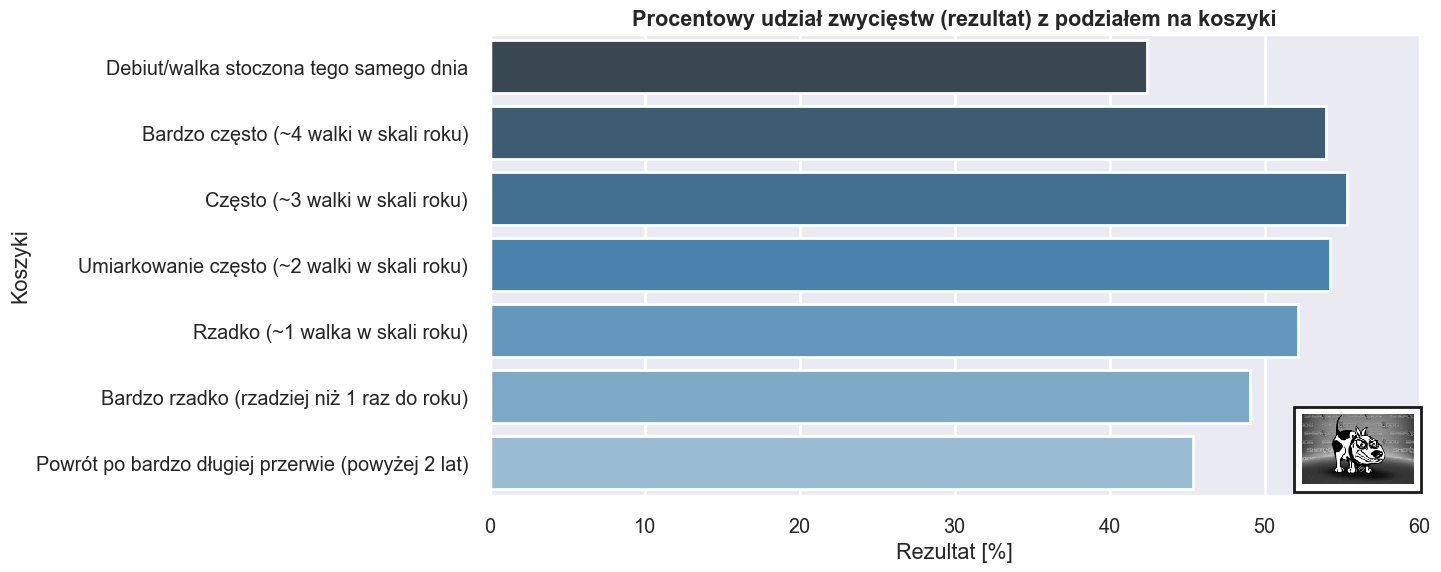

In [362]:
# Wykres przedstawiający rezultat wyrażony w procentach z podziałem na koszyki dla całej bazy zawdoniczej sherdoga.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(sherdog_true_pct.values, sherdog_true_pct.index, palette="Blues_d")
ax.set_xlim(0, 60)
ax.set(xlabel='Rezultat [%]', ylabel='Koszyki')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.4)
ab = AnnotationBbox(imagebox, (56, 5.8))
ax.add_artist(ab)

plt.title('Procentowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
plt.show()

In [363]:
# Przedstawienie dynamiki zmian rezultatu dla poszczególnych grup.
sherdog_pct_sorted.pct_change()

Często (~3 walki w skali roku)                            NaN
Umiarkowanie często (~2 walki w skali roku)         -0.020054
Bardzo często (~4 walki w skali roku)               -0.004533
Rzadko (~1 walka w skali roku)                      -0.033720
Bardzo rzadko (rzadziej niż 1 raz do roku)          -0.059397
Powrót po bardzo długiej przerwie (powyżej 2 lat)   -0.074272
Debiut/walka stoczona tego samego dnia              -0.065864
Name: Descriptive_interval, dtype: float64

In [364]:
# Ilość obserwacji przypadająca na dany koszyk.
all_fights_count

Debiut/walka stoczona tego samego dnia               138034
Bardzo często (~4 walki w skali roku)                130115
Rzadko (~1 walka w skali roku)                        74233
Umiarkowanie często (~2 walki w skali roku)           61891
Często (~3 walki w skali roku)                        45663
Bardzo rzadko (rzadziej niż 1 raz do roku)            35188
Powrót po bardzo długiej przerwie (powyżej 2 lat)     19223
Name: Descriptive_interval, dtype: int64

Największa liczba obserwacji została zarejestrowana dla grupy debiutantów/walk odbytych tego samego dnia oraz dla interwałów czasowych o dużej częstotliwości. Nie jest zaskoczeniem, że najmniejsza ilość obserwacji dotyczy grupy powracającej po ponad 2-letniej przerwie oraz dla tych, którzy swoje walki toczyli w odstępie dłuższym niż rok. Taka strategia nie byłaby uzasadniona ani sportowo, ani ekonomicznie, więc najczęściej jest efektem czynników niezależnych od fightera, a nie jego świadomą strategią.

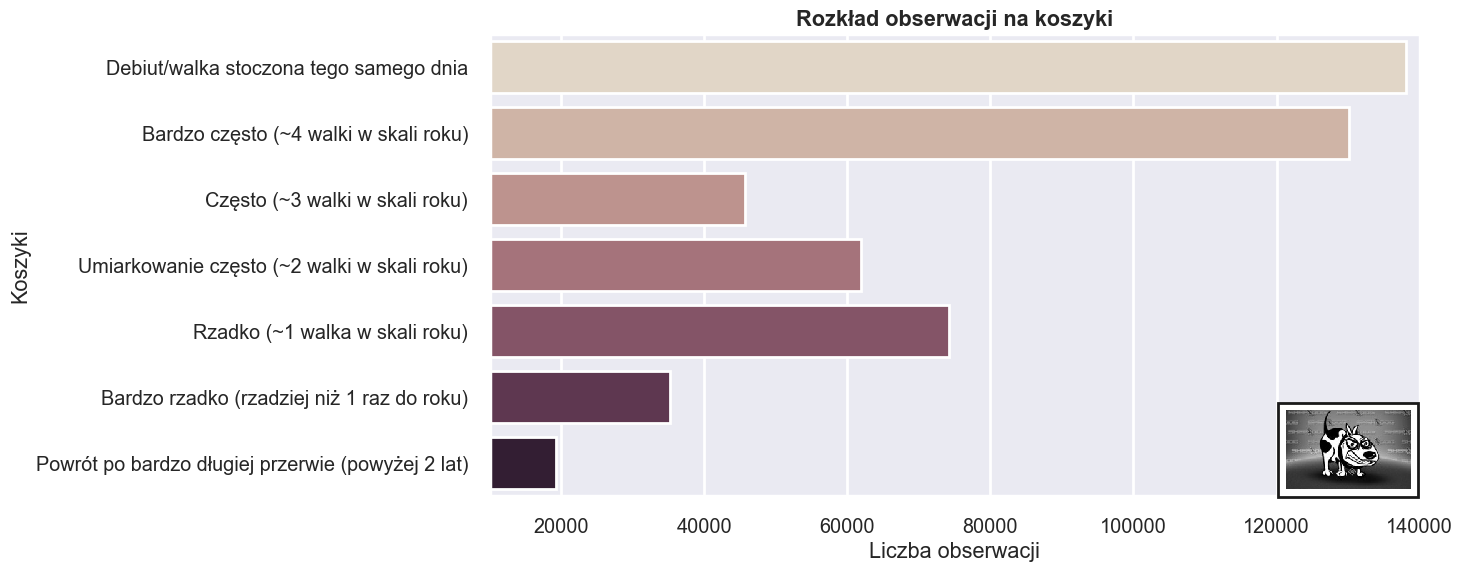

In [365]:
# Wykres przedstawiający liczbę obserwacji z podziałem na koszyki całej bazy zawdoniczej Sherdoga. 
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(all_fights_count.values, all_fights_count.index, palette="ch:.25")
ax.set_xlim(10000, 140000)
ax.set(xlabel='Liczba obserwacji', ylabel='Koszyki')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.45)
ab = AnnotationBbox(imagebox, (130000, 5.8))
ax.add_artist(ab)

plt.title('Rozkład obserwacji na koszyki', fontweight='bold')
plt.show()

In [366]:
# Utworzenie tabeli krzyżowej na potrzeby wizualizacji rozkładu rostrzygnięć na koszyki.
sherdog_cross = pd.crosstab(sherdog_selected_data['Descriptive_interval'], sherdog_selected_data['Result'])

<Figure size 1000x600 with 0 Axes>

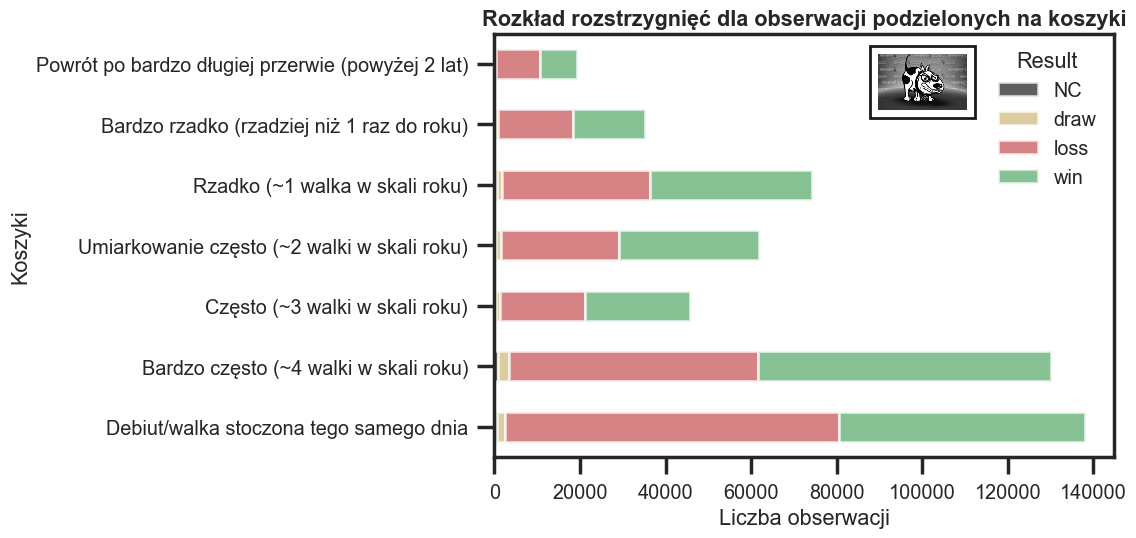

In [367]:
# Wykres przedstawiający rozkład rozstrzygnięć dla poszczególnych koszyków w bazie zawodniczej Sherdoga. 
plt.figure(figsize=(10,6), dpi= 100)
plt.style.use('seaborn')
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = sherdog_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Koszyki', xlabel='Liczba obserwacji')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.32)
ab = AnnotationBbox(imagebox, (100000, 5.7))
ax.add_artist(ab)

plt.title('Rozkład rozstrzygnięć dla obserwacji podzielonych na koszyki', fontweight='bold')
plt.show()

## Segment 3: *Wczytanie, przygotowanie i analiza danych dla rosteru UFC*

In [368]:
import re

In [369]:
# Wczytanie danych dla bazy zawodniczej UFC.
ufc_data = pd.read_csv('sherdog-UFC_roster.csv', header=0, sep=";", engine='python')

In [370]:
ufc_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time
0,Shamil Abdurakhimov,Curtis Blaydes,loss,UFC 242 - Khabib vs. Poirier,Sep / 07 / 2019,TKO (Elbow and Punch),Marc Goddard,2,02:22
1,Shamil Abdurakhimov,Marcin Tybura,win,UFC Fight Night 149 - Overeem vs. Oleynik,Apr / 20 / 2019,TKO (Punches),Herb Dean,2,03:15
2,Shamil Abdurakhimov,Andrei Arlovski,win,UFC Fight Night 136 - Hunt vs. Oleynik,Sep / 15 / 2018,Decision (Unanimous),Leon Roberts,3,05:00
3,Shamil Abdurakhimov,Chase Sherman,win,UFC Fight Night 122 - Bisping vs. Gastelum,Nov / 25 / 2017,KO (Punches),Steve Perceval,1,01:24
4,Shamil Abdurakhimov,Derrick Lewis,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,Dec / 09 / 2016,TKO (Punches),Dan Miragliotta,4,03:42
5,Shamil Abdurakhimov,Walt Harris,win,UFC Fight Night 96 - Lineker vs. Dodson,Oct / 01 / 2016,Decision (Split),Herb Dean,3,05:00
6,Shamil Abdurakhimov,Anthony Hamilton,win,UFC Fight Night 83 - Cerrone vs. Oliveira,Feb / 21 / 2016,Decision (Unanimous),Chip Snider,3,05:00
7,Shamil Abdurakhimov,Timothy Johnson,loss,UFC Fight Night 63 - Mendes vs. Lamas,Apr / 04 / 2015,TKO (Punches),Mike King,1,04:57
8,Shamil Abdurakhimov,Kenny Garner,win,M-1 Challenge 49 - Battle in the Mountains,Jun / 07 / 2014,Decision (Unanimous),Viktor Korneev,3,05:00
9,Shamil Abdurakhimov,Neil Grove,win,Tech-Krep FC - Southern Front 2,Oct / 04 / 2013,Decision (Unanimous),Ashot Ashughyan,3,05:00


In [371]:
# Utworzenie kopii obiektu DataFrame z ograniczeniem do interesujących nas kolumn.
ufc_selected_data = ufc_data[['Fighter', 'Result', 'Event_date']].copy()

In [372]:
# Sprawdzenie, czy nie pojawiły się żadne brakujące rekordy w tabeli z datą eventu.
ufc_selected_data[ufc_selected_data['Event_date'].isna()]

,Fighter,Result,Event_date


In [373]:
# Konwersja danych w tabeli Event_date z zapisu w formie string do zunifikowanego formatu daty.
ufc_converted_dates = []
for i in range(len(ufc_selected_data['Event_date'])):
    ufc_converted_dates.append(parse(ufc_selected_data['Event_date'][i]))

In [374]:
# Przypisanie skonwertowanych dat do tabeli Event_date.
ufc_selected_data['Event_date'] = ufc_converted_dates

In [375]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date
0,Shamil Abdurakhimov,loss,2019-09-07
1,Shamil Abdurakhimov,win,2019-04-20
2,Shamil Abdurakhimov,win,2018-09-15
3,Shamil Abdurakhimov,win,2017-11-25
4,Shamil Abdurakhimov,loss,2016-12-09
5,Shamil Abdurakhimov,win,2016-10-01
6,Shamil Abdurakhimov,win,2016-02-21
7,Shamil Abdurakhimov,loss,2015-04-04
8,Shamil Abdurakhimov,win,2014-06-07
9,Shamil Abdurakhimov,win,2013-10-04


In [376]:
# Utworzenie interwałów czasowych pomiędzy walkami dla każdego z zawodników.
ufc_intervals = []
for i in range(len(ufc_selected_data['Fighter']) - 1):
    if ufc_selected_data['Fighter'][i] == ufc_selected_data['Fighter'][i + 1]:
        ufc_intervals.append(ufc_selected_data['Event_date'][i] - ufc_selected_data['Event_date'][i + 1])
        ufc_intervals[i] = ufc_intervals[i].days
    else:
        ufc_intervals.append(0)
ufc_intervals.append(0)   # ostatni interwał czasowy dla ostatniego zawodnika w bazie danych wynosił będzie 0.

In [377]:
# Przypisanie utworzonych interwałów do nowej kolumny w tabeli.
ufc_selected_data['Time_interval'] = ufc_intervals

In [378]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval
0,Shamil Abdurakhimov,loss,2019-09-07,140
1,Shamil Abdurakhimov,win,2019-04-20,217
2,Shamil Abdurakhimov,win,2018-09-15,294
3,Shamil Abdurakhimov,win,2017-11-25,351
4,Shamil Abdurakhimov,loss,2016-12-09,69
5,Shamil Abdurakhimov,win,2016-10-01,223
6,Shamil Abdurakhimov,win,2016-02-21,323
7,Shamil Abdurakhimov,loss,2015-04-04,301
8,Shamil Abdurakhimov,win,2014-06-07,246
9,Shamil Abdurakhimov,win,2013-10-04,551


Dla bazy zawodników z rosteru UFC powtarzamy te same czynności, które wcześniej prowadziły do analizy całej bazy Sherdoga. Przypiszemy zawodnikom UFC te same nazwy koszyków o tych samych właściwościach i nazwiemy je dokładnie tak samo, co ułatwi nam późniejsze zestawienie wyników.

In [379]:
# Przygotowanie koszyków oraz etykiet dla grup i przypisanie ich do zmiennej cats.
bins_ufc = [0, 1, 91, 121, 183, 366, 729, 10000]
cats_ufc = pd.cut(ufc_selected_data['Time_interval'], bins_ufc, labels=group_names, right=False)

In [380]:
# Dodanie kolumny z opisowy interwałem czasowym.
ufc_selected_data['Descriptive_interval'] = cats_ufc

In [381]:
ufc_selected_data[0:20]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku)
1,Shamil Abdurakhimov,win,2019-04-20,217,Rzadko (~1 walka w skali roku)
2,Shamil Abdurakhimov,win,2018-09-15,294,Rzadko (~1 walka w skali roku)
3,Shamil Abdurakhimov,win,2017-11-25,351,Rzadko (~1 walka w skali roku)
4,Shamil Abdurakhimov,loss,2016-12-09,69,Bardzo często (~4 walki w skali roku)
5,Shamil Abdurakhimov,win,2016-10-01,223,Rzadko (~1 walka w skali roku)
6,Shamil Abdurakhimov,win,2016-02-21,323,Rzadko (~1 walka w skali roku)
7,Shamil Abdurakhimov,loss,2015-04-04,301,Rzadko (~1 walka w skali roku)
8,Shamil Abdurakhimov,win,2014-06-07,246,Rzadko (~1 walka w skali roku)
9,Shamil Abdurakhimov,win,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku)


In [382]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej.
ufc_brackets = ufc_selected_data['Descriptive_interval']

In [383]:
# Utworzenie zmiennych, gdzie przechowywana będzie sumaryczna ilość walk dla poszczególnych kryteriów.
ufc_all_fights_count = ufc_brackets.value_counts()
ufc_win_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'win'].value_counts()
ufc_loss_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'loss'].value_counts()
ufc_draw_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'draw'].value_counts()
ufc_nc_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'NC'].value_counts()

In [384]:
# Suma wszystkich walk w bazie UFC.
ufc_all_fights_count.sum()

12979

In [385]:
# Suma wszystkich walk w bazie UFC zakończonych wygraną.
ufc_win_fights_count.sum()

9730

In [386]:
# Suma wszystkich walk w bazie UFC zakończonych przegraną.
ufc_loss_fights_count.sum()

3063

In [387]:
# Suma wszystkich walk w bazie zawodniczej zakończonych remisem.
ufc_draw_fights_count.sum()

90

In [388]:
# Suma wszystkich walk w bazie zawodniczej zakończonych jako no-contest.
ufc_nc_fights_count.sum()

96

In [389]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
ufc_selected_data[ufc_selected_data['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval


In [390]:
# Weryfikacja, czy suma wszystkich walk zakwalifikowanych do koszyków, jest równa sumie wszystkich kategorii.
ufc_sum_of_brackets = (ufc_win_fights_count.sum() + ufc_loss_fights_count.sum() + ufc_draw_fights_count.sum() + 
ufc_nc_fights_count.sum())

if ufc_all_fights_count.sum() == ufc_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [391]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
ufc_pct = ufc_win_fights_count/(ufc_win_fights_count + ufc_loss_fights_count)

In [392]:
# Posortowanie wyników w kolejności malejącej.
ufc_pct_sorted = ufc_pct.sort_values(ascending=False)

In [393]:
# Konwersja ułamków na liczby dające się przedstawić w %.
ufc_true_pct = ufc_pct * 100

In [394]:
ufc_pct_sorted

Debiut/walka stoczona tego samego dnia               0.892052
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.830357
Bardzo często (~4 walki w skali roku)                0.800858
Często (~3 walki w skali roku)                       0.742574
Umiarkowanie często (~2 walki w skali roku)          0.734148
Rzadko (~1 walka w skali roku)                       0.722242
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.703540
Name: Descriptive_interval, dtype: float64

Pierwszym rzucającym się w oczy elementem jest produkt uboczny tej analizy - **dla rostera UFC każdy koszyk osiągnął *20-30 punktów procentowych* wyższy rezultat, aniżeli miało to miejsce dla całej bazy zawodniczej Sherdoga**. Wniosek jest oczywisty - zawodnicy UFC są lepsi (wygrywają większą część swoich walk), aniżeli przeciętny zawodnik MMA. Nie powinno być to żadnym zaskoczeniem, wszak UFC jest superligą i jednocześniej najbardziej elitarną obecnie organizacją MMA na świecie. 
Kolejną ciekawostką jest znaczenie debiutu - ***89%* aktualnego rostera UFC zanotowało zwycięstwo w swojej pierwszej walce w karierze i jest to koszyk z najwyższym rezultatem** (niecałe *20%* obserwacji w tym koszyku to walki turniejowe-jednodniowe, natomiast ponad 80% to walki debiutanckie).

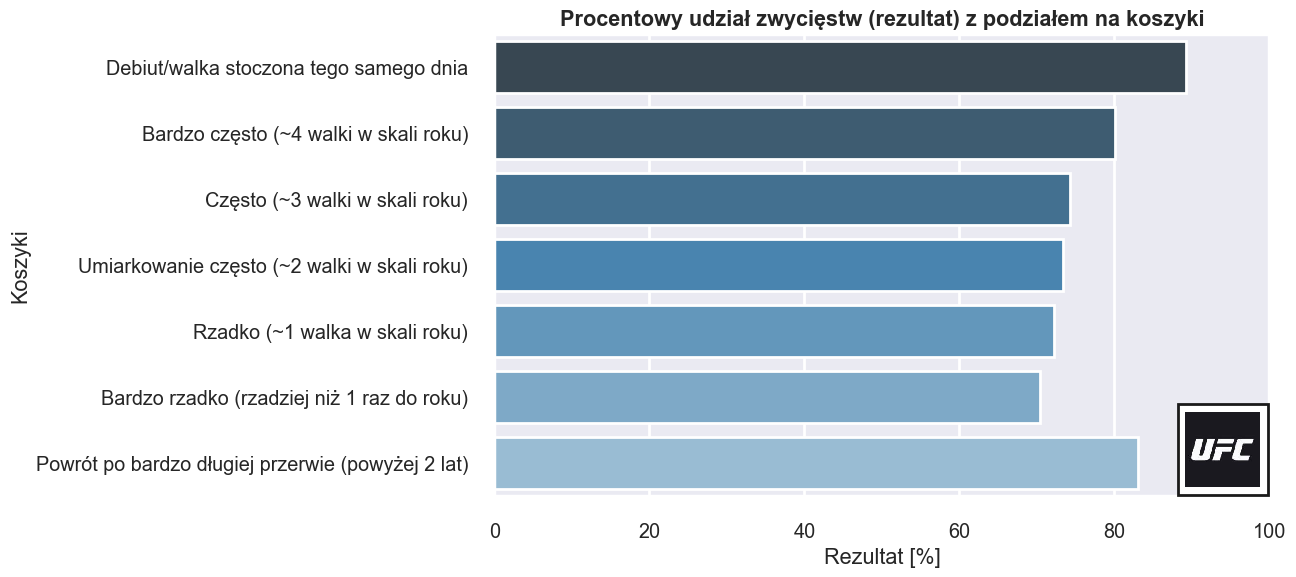

In [395]:
# Wykres przedstawiający rezultat wyrażony w procentach z podziałem na koszyki dla zawodników rosteru UFC.
plt.figure(figsize=(10,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(ufc_true_pct.values, ufc_true_pct.index, palette="Blues_d")
ax.set_xlim(0, 100)
ax.set(xlabel='Rezultat [%]', ylabel='Koszyki')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.3)
ab = AnnotationBbox(imagebox, (94, 5.8))
ax.add_artist(ab)

plt.title('Procentowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
plt.show()

In [396]:
# Sprawdzenie ile rekordów przypadło na poszczególne koszyki.
ufc_all_fights_count

Bardzo często (~4 walki w skali roku)                3547
Umiarkowanie często (~2 walki w skali roku)          3065
Rzadko (~1 walka w skali roku)                       2861
Często (~3 walki w skali roku)                       1851
Debiut/walka stoczona tego samego dnia                851
Bardzo rzadko (rzadziej niż 1 raz do roku)            689
Powrót po bardzo długiej przerwie (powyżej 2 lat)     115
Name: Descriptive_interval, dtype: int64

Pewnym zaskoczeniem jest bardzo wysoki wynik dla koszyka zawodników wracających po ponad 2-letniej przerwie. Przyjrzyjmy się temu bliżej: odnotowaliśmy raptem 115 rekordów dla tego koszyka w gronie obecnych zawodników UFC. Stanowi to mniej niż *1%* wszystkich walk odnotowanych dla aktualnego rostera UFC. W przypadku bazy Sherdoga kategoria ta również była reprezentowana przez najmniejszą liczbę obserwacji, jednak stanowiła ona niemal *4%* wszystkich walk. Z tego względu zachowałbym tutaj szczególną ostrożność z wyciąganiem wniosków na podstawie tak małej ilości dostępnych danych.

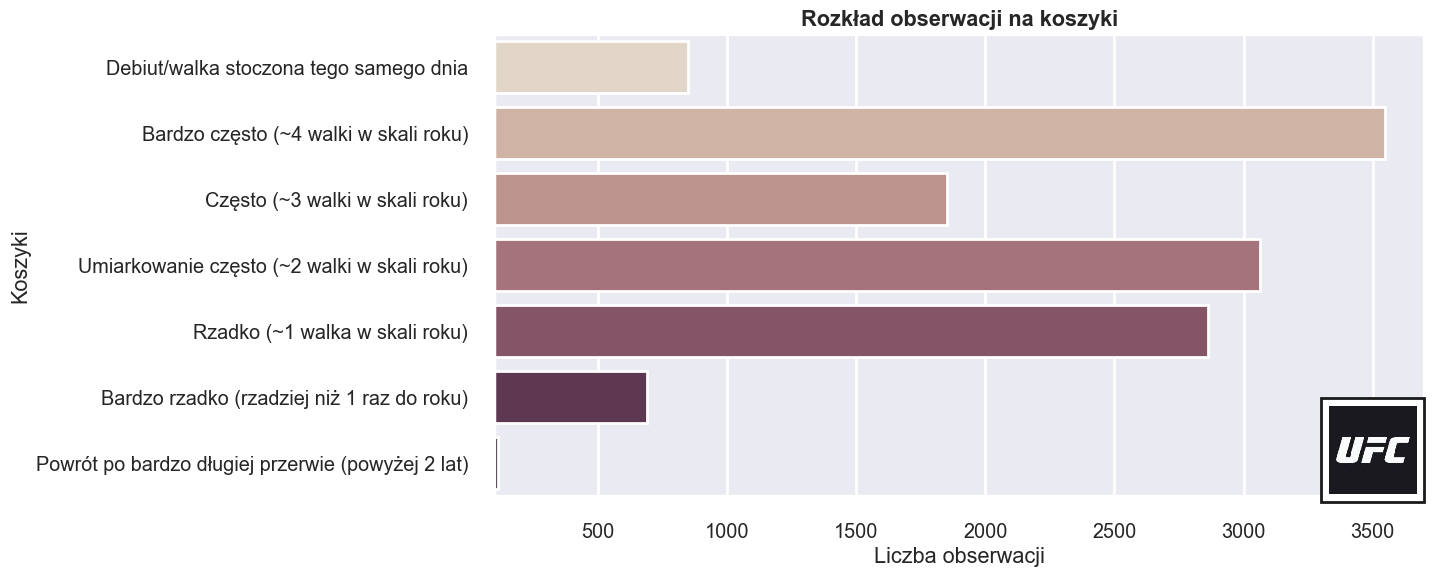

In [397]:
# Wykres przedstawiający liczbę obserwacji z podziałem na koszyki dla rosteru UFC. 
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(ufc_all_fights_count.values, ufc_all_fights_count.index, palette="ch:.25")
ax.set_xlim(100, 3700)
ax.set(xlabel='Liczba obserwacji', ylabel='Koszyki')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.35)
ab = AnnotationBbox(imagebox, (3500, 5.8))
ax.add_artist(ab)

plt.title('Rozkład obserwacji na koszyki', fontweight='bold')
plt.show()

In [398]:
# Udział koszyka "Powrót po bardzo długiej przerwie (powyżej 2 lat)" w całościowym zestawieniu zawodników UFC.
ufc_all_fights_count[6] / ufc_all_fights_count.sum()

0.008860466908082287

In [399]:
# Udział koszyka "Powrót po bardzo długiej przerwie (powyżej 2 lat)" w zestawieniu bazy Sherdoga.
all_fights_count[6] / all_fights_count.sum()

0.03811463139465487

Dla koszyków reprezentujących walki w częstotliwości od 1 do 3 walk w skali roku widzimy jedynie nieznacznie różnice wyrażone w punktach procentowych. Sytuacja ta przypomina rezultat dla całej bazy zawodniczej, z tą jednak różnicą, że rezultaty dla wszystkich tych kategorii są w przypadku zawodników UFC znacznie wyższe. Biorąc pod uwagę tak niewielkie różnice między tymi interwałami, **możemy wnioskować, że to czy zawodnik zdecyduje się walczyć 3, 2, 1 raz do roku nie wpłynie w żaden sposób na zwiększenie, lub zmniejszenie jego szansy na odniesienie zwycięstwa**. Wniosek ten jest uzasadniony zarówno dla całej bazy zawodniczej, jak i dla zawodników będących obecnie częścią rostera UFC.

Ciekawym interwałem jest ten z etykietą - "Bardzo często (~4 walki w skali roku)". Dla całej bazy zawodniczej osiągnął on trzeci najwyższy rezultat (niecałe *54%*). Na tej samej pozycji uplasował się wśród zawodników rostera UFC, z tą jednak różnicą, że osiągnął wynik o około 6 punktów procentowych wyższy od grupy interwałów opisanych w poprzednim akapicie. Takiej różnicy nie było jednak w przypadku całej bazy zawodniczej, gdzie różnice między interwałem - "Bardzo Często" a interwałami o częstotliwości od 1 do 3 walk w skali roku, nie przekraczały *3 punktów procentowych*. 
Możliwym wytłumaczeniem jest tutaj praktyka, którą wielu zawodników w drodze do UFC stosowało, a więc branie jak największej liczby walk w jak najkrótszym czasie, nawet jeśli poziom oponenta budził wątpliwości. Liczba zwycięstw przedkładana była ponad jakość - o takiej strategii otwarcie mówiło wielu menadżerów próbujących wprowadzić swoich podopiecznych pod skrzydła UFC.

Powyższa obserwacja jest wystarczającym powodem, żeby przyjrzeć się danym, jedynie z perspektywy walk odbytych pod sztandarem UFC i zbadać, czy taka szaleńcza częstotliwość, rzeczywiście przynosi zawodnikom pozytywne rezultaty, czy może była jedynie dobrą strategią w obliczu walk z zawodnikami z "niższej półki".

In [400]:
# Utworzenie tabeli krzyżowej na potrzeby wizualizacji rozkładu rezultatów na koszyki.
ufc_cross = pd.crosstab(ufc_selected_data['Descriptive_interval'], ufc_selected_data['Result'])

<Figure size 900x600 with 0 Axes>

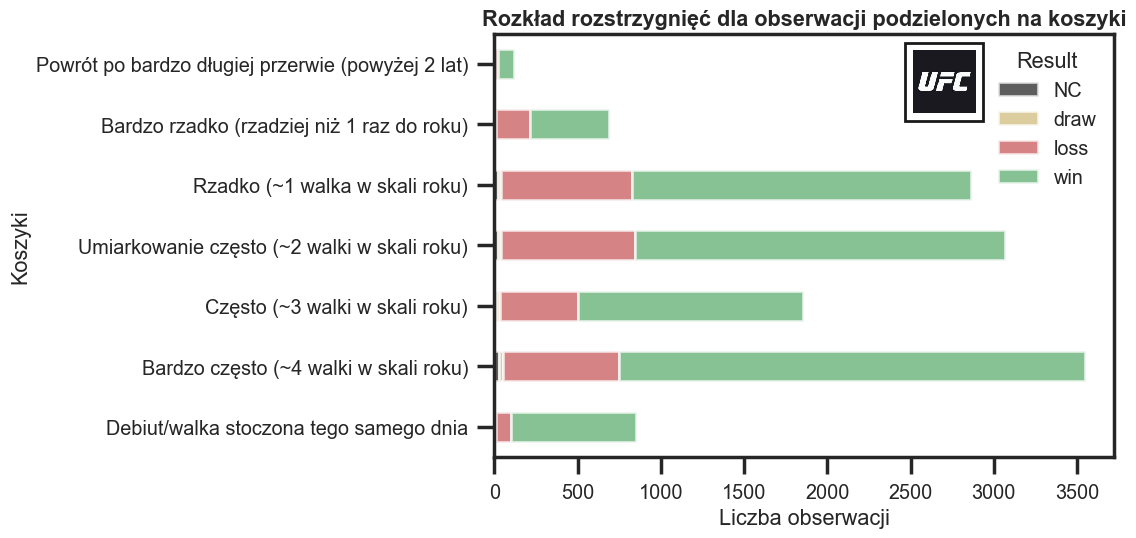

In [401]:
# Wykres przedstawiający rozkład rozstrzygnięć dla poszczególnych koszyków dla rostera UFC.
plt.figure(figsize=(9,6), dpi= 100)
plt.style.use('seaborn')
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = ufc_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Koszyki', xlabel='Liczba obserwacji')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.25)
ab = AnnotationBbox(imagebox, (2700, 5.7))
ax.add_artist(ab)

plt.title('Rozkład rozstrzygnięć dla obserwacji podzielonych na koszyki', fontweight='bold')
plt.show()

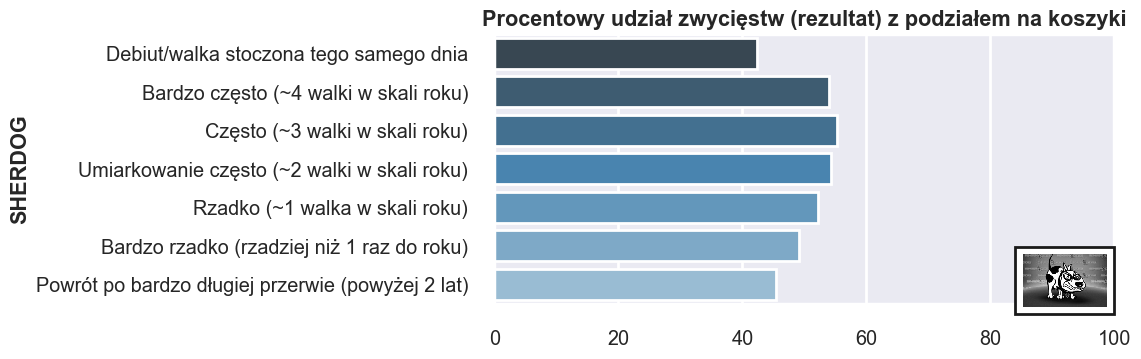

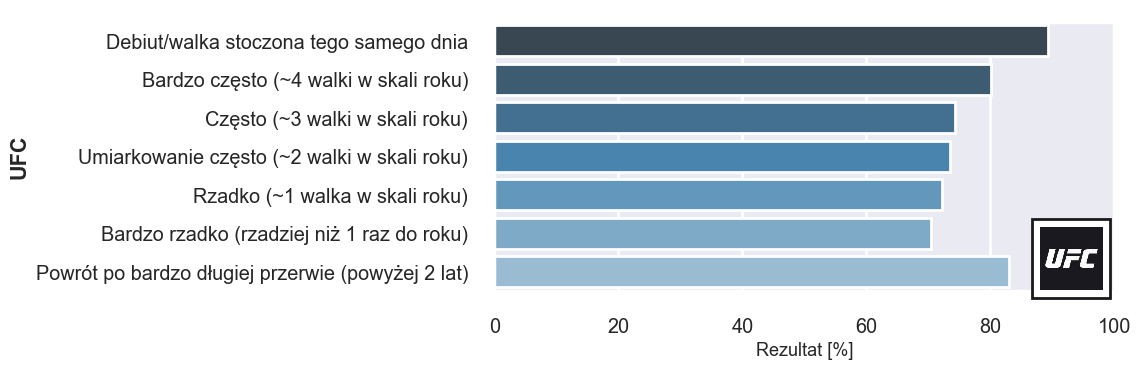

In [402]:
# Zestawienie wykresów z procentowym udziałem zwycięstw.
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)

plt.figure(figsize=(8,3.5), dpi= 100)

ax1 = sns.barplot(sherdog_true_pct.values, sherdog_true_pct.index, palette="Blues_d")
ax1.set_xlim(0, 100)
ax1.set_ylabel('SHERDOG', fontweight='heavy')

imagebox = OffsetImage(sher_logo, zoom=0.3)
ab = AnnotationBbox(imagebox, (92, 5.9))
ax1.add_artist(ab)

plt.figure(figsize=(8,3.5), dpi= 100)
ax2 = sns.barplot(ufc_true_pct.values, ufc_true_pct.index, palette="Blues_d")
ax2.set_xlim(0, 100)
ax2.set_xlabel('Rezultat [%]', fontsize='smaller')
ax2.set_ylabel('UFC', fontweight='heavy')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
ab2 = AnnotationBbox(imagebox, (93, 5.65))
ax2.add_artist(ab2)

ax1.set_title('Procentowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
plt.show()

## Segment 4: *Analiza walk stoczonych pod banderą UFC, podział na płeć oraz kategorie wagowe*

In [403]:
# Utworzenie kopii tabeli Event z oryginalnego DataFrame.
ufc_selected_data['Event'] = ufc_data['Event'].copy()

In [404]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Event
0,Shamil Abdurakhimov,loss,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku),UFC 242 - Khabib vs. Poirier
1,Shamil Abdurakhimov,win,2019-04-20,217,Rzadko (~1 walka w skali roku),UFC Fight Night 149 - Overeem vs. Oleynik
2,Shamil Abdurakhimov,win,2018-09-15,294,Rzadko (~1 walka w skali roku),UFC Fight Night 136 - Hunt vs. Oleynik
3,Shamil Abdurakhimov,win,2017-11-25,351,Rzadko (~1 walka w skali roku),UFC Fight Night 122 - Bisping vs. Gastelum
4,Shamil Abdurakhimov,loss,2016-12-09,69,Bardzo często (~4 walki w skali roku),UFC Fight Night 102 - Lewis vs. Abdurakhimov
5,Shamil Abdurakhimov,win,2016-10-01,223,Rzadko (~1 walka w skali roku),UFC Fight Night 96 - Lineker vs. Dodson
6,Shamil Abdurakhimov,win,2016-02-21,323,Rzadko (~1 walka w skali roku),UFC Fight Night 83 - Cerrone vs. Oliveira
7,Shamil Abdurakhimov,loss,2015-04-04,301,Rzadko (~1 walka w skali roku),UFC Fight Night 63 - Mendes vs. Lamas
8,Shamil Abdurakhimov,win,2014-06-07,246,Rzadko (~1 walka w skali roku),M-1 Challenge 49 - Battle in the Mountains
9,Shamil Abdurakhimov,win,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku),Tech-Krep FC - Southern Front 2


In [405]:
# Zapisanie kolejności wyświetlanych kolumn w formie listy.
columns_ufc = ufc_selected_data.columns.tolist()

In [406]:
columns_ufc

['Fighter',
 'Result',
 'Event_date',
 'Time_interval',
 'Descriptive_interval',
 'Event']

In [407]:
# Zamiana kolejności kolumn w tabeli.
columns_ufc = [columns_ufc[0], columns_ufc[1], columns_ufc[-1], columns_ufc[2], columns_ufc[3], columns_ufc[4]]

In [408]:
# Przypisanie zmienionej kolejności do DataFrame'u.
ufc_selected_data = ufc_selected_data[columns_ufc]

In [409]:
ufc_selected_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku)
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Rzadko (~1 walka w skali roku)
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku)


In [410]:
# Utworzenie zmiennej, która zawierać będzie jedynie rekordy dla walk stoczonych pod banderą UFC.
ufc_events_only = ufc_selected_data[ufc_selected_data['Event'].str.contains("^UFC\s", flags=re.IGNORECASE, regex=True)].copy()

In [411]:
ufc_events_only[0:20]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku)
25,Klidson Abreu,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Często (~3 walki w skali roku)
26,Klidson Abreu,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Umiarkowanie często (~2 walki w skali roku)


In [412]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej
ufc_events_brackets = ufc_events_only['Descriptive_interval']

In [413]:
# Utworzenie zmiennych, gdzie przechowywana będzie sumaryczna ilość walk dla poszczególnych kryteriów.
ufc_events_all_fights_count = ufc_events_brackets.value_counts()
ufc_events_win_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'win'].value_counts()
ufc_events_loss_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'loss'].value_counts()
ufc_events_draw_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'draw'].value_counts()
ufc_events_nc_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'NC'].value_counts()

In [414]:
# Suma wszystkich walk zawodników rostera UFC pod banderą UFC.
ufc_events_all_fights_count.sum()

4755

In [415]:
# Suma wszystkich wygranych walk zawodników rostera UFC pod banderą UFC.
ufc_events_win_fights_count.sum()

2796

In [416]:
# Suma wszystkich przegranych walk zawodników rostera UFC pod banderą UFC.
ufc_events_loss_fights_count.sum()

1889

In [417]:
# Suma wszystkich zremisowanych walk zawodników rostera UFC pod banderą UFC.
ufc_events_draw_fights_count.sum()

28

In [418]:
# Suma wszystkich walk zawodników rostera UFC pod banderą UFC zakończonych jako no-contest.
ufc_events_nc_fights_count.sum()

42

In [419]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
ufc_events_only[ufc_events_only['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval


In [420]:
# Weryfikacja czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii.
ufc_events_sum_of_brackets = (ufc_events_win_fights_count.sum() + ufc_events_loss_fights_count.sum() + 
ufc_events_draw_fights_count.sum() + ufc_events_nc_fights_count.sum())

if ufc_events_all_fights_count.sum() == ufc_events_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [421]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
ufc_events_pct = ufc_events_win_fights_count/(ufc_events_win_fights_count + ufc_events_loss_fights_count)

In [422]:
# Posortowanie wyników w kolejności malejącej.
ufc_events_pct_sorted = ufc_events_pct.sort_values(ascending=False)

In [423]:
ufc_events_pct_sorted

Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.666667
Rzadko (~1 walka w skali roku)                       0.616059
Umiarkowanie często (~2 walki w skali roku)          0.610892
Często (~3 walki w skali roku)                       0.582744
Bardzo często (~4 walki w skali roku)                0.555172
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.544413
Debiut/walka stoczona tego samego dnia               0.000000
Name: Descriptive_interval, dtype: float64

In [424]:
ufc_events_all_fights_count

Umiarkowanie często (~2 walki w skali roku)          1542
Rzadko (~1 walka w skali roku)                       1504
Często (~3 walki w skali roku)                        721
Bardzo często (~4 walki w skali roku)                 587
Bardzo rzadko (rzadziej niż 1 raz do roku)            355
Powrót po bardzo długiej przerwie (powyżej 2 lat)      45
Debiut/walka stoczona tego samego dnia                  1
Name: Descriptive_interval, dtype: int64

Jak się okazuje, najwyższy współczynnik procentowy dla walk wewnątrz organizacji UFC mają fighterzy wracający do walki po przerwie powyżej 2 lat, co muszę przyznać, jest dość zaskakujące. Pojawia się zatem zasadnicze pytanie, czy zawodnik wracający po tak długiej rozłące z oktagonem rzeczywiście ma większe szanse na zwycięstwo, wyłączając czynnik poziomu przeciwnika, czy może jednak powracający po przerwie fighterzy są w UFC traktowani ulgowo i dostają nieco słabszych przeciwników. Niewykluczone, że to właśnie klasa przeciwnika jest tutaj czynnikiem ukrytym, który decyduje o takich wynikach analizy. Może być również tak, że oba te czynniki mają wpływ na ostateczny wynik.

Przechodząc dalej, możemy zaobserwować 3 kategorie, które niemal nie różnią się rezultatem: rzadko, umiarkowanie często oraz często. Wygląda zatem na to, że potwierdziliśmy również w przypadku walk wewnątrz UFC, naszą tezę o tym, że **decyzja zawodnika, aby walczyć 3, 2 lub 1 raz do roku nie wpłynie w żaden sposób na zwiększenie lub zmniejszenie jego szansy na odniesienie zwycięstwa.**

Okazuje się również, że kategoria: Bardzo często (częstotliwość 4 walk w roku) z pozytywnie odstającej kategorii przy analizie wszystkich walk dla rosteru UFC, zmieniła się w negatywnie odstającą (około 6 punktów procentowych mniej niż dla intensywności w przedziale 1 do 3). Wygląda na to, że są pewne podstawy, aby rzeczywiście sądzić, że tak dobry rezultat, jaki osiągnęła ta grupa podczas analizy rostera, mógł być spowodowany klasą przeciwników. Natomiast będąc już w UFC toczenie walk z taką częstotliwością może obniżyć szansę zawodnika na wygraną.

Najniższy wynik osiągnęła ponownie grupa walcząca rzadziej niż 1 raz do roku - **wygląda na to, że ta intensywność nie sprzyjała zawodnikom nie tylko poza UFC, ale i w samej organizacji, obniżając ich szanse na pozytywny rezultat walki.**

Udało nam się również odfiltrować kategorię debiutu, która miała niesamowicie wysoki wskaźnik wśród zawodników rostera UFC - w samym UFC mamy zaledwie jeden przypadek debiutu (CM Punk) i, co nie jest zaskoczeniem, zakończył się on porażką debiutanta.

Liczba obserwacji dla konkretnych koszyków potwierdziła wcześniejsze przypuszczenia - dominuje częstotliwość 2 lub 1 walki w skali roku.

In [425]:
ufc_events_only[ufc_events_only['Descriptive_interval'] == 'Debiut/walka stoczona tego samego dnia']

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
8396,Phil Brooks,loss,UFC 203 - Miocic vs. Overeem,2016-09-10,0,Debiut/walka stoczona tego samego dnia


In [426]:
# Konwersja ułamków na liczby dające się przedstawić w %.
ufc_events_true_pct = ufc_events_pct * 100

In [427]:
# Utworzenie tabeli krzyżowej na potrzeby wizualizacji rozkładu rezultatów na koszyki.
ufc_events_cross = pd.crosstab(ufc_events_only['Descriptive_interval'], ufc_events_only['Result'])

<Figure size 1200x600 with 0 Axes>

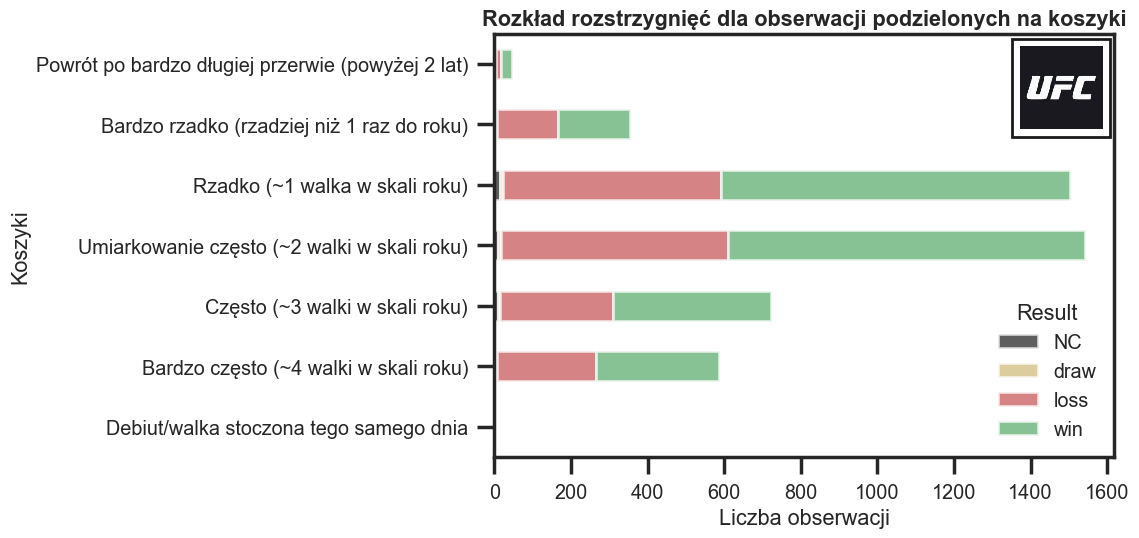

In [428]:
# Wykres przedstawiający rozkład rozstrzygnięć poszczególnych koszyków dla walk zawodników rostera UFC w UFC.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = ufc_events_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Koszyki', xlabel='Liczba obserwacji')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.33)
ab = AnnotationBbox(imagebox, (1480, 5.6))
ax.add_artist(ab)

plt.title('Rozkład rozstrzygnięć dla obserwacji podzielonych na koszyki', fontweight='bold')
plt.show()

In [429]:
# Wczytanie pliku zawierającego informacje o dywizjach wagowych dla fighterów rostera UFC.
roster = pd.read_csv('ufc-roster_v3.csv', header=0, sep=",", engine='python')

In [430]:
roster[0:10]

,Name,Division,Nickname
0,Shamil Abdurakhimov,Heavyweight,Abrek
1,Klidson Abreu,Light Heavyweight,White Bear
2,Juan Adams,Heavyweight,The Kraken
3,Israel Adesanya,Middleweight,The Last Stylebender
4,Kevin Aguilar,Featherweight,Angel of Death
5,Omari Akhmedov,Middleweight,Wolverine
6,Rostem Akman,Welterweight,NaN
7,Heili Alateng,Bantamweight,The Mongolian Knight
8,Junior Albini,Heavyweight,Baby
9,Iuri Alcantara,Bantamweight,Marajo


In [431]:
# Unifikacja zapisu imion i nazwisk.
ufc_events_only.loc[:, ['Fighter']] = ufc_events_only['Fighter'].str.upper()
roster.loc[:, 'Name'] = roster['Name'].str.upper()

In [432]:
ufc_events_only[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,SHAMIL ABDURAKHIMOV,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku)
1,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku)
2,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku)
3,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku)
4,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku)
5,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku)
6,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku)
7,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku)
25,KLIDSON ABREU,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Często (~3 walki w skali roku)
26,KLIDSON ABREU,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Umiarkowanie często (~2 walki w skali roku)


In [433]:
roster[0:10]

,Name,Division,Nickname
0,SHAMIL ABDURAKHIMOV,Heavyweight,Abrek
1,KLIDSON ABREU,Light Heavyweight,White Bear
2,JUAN ADAMS,Heavyweight,The Kraken
3,ISRAEL ADESANYA,Middleweight,The Last Stylebender
4,KEVIN AGUILAR,Featherweight,Angel of Death
5,OMARI AKHMEDOV,Middleweight,Wolverine
6,ROSTEM AKMAN,Welterweight,NaN
7,HEILI ALATENG,Bantamweight,The Mongolian Knight
8,JUNIOR ALBINI,Heavyweight,Baby
9,IURI ALCANTARA,Bantamweight,Marajo


In [434]:
# Połączenie obu źródeł danych w jeden wraz z odrzuceniem zbędnych kolumn.
ufc_events_only_div = pd.merge(ufc_events_only, roster, left_on='Fighter', 
                               right_on='Name', how='left').drop(['Name', 'Nickname'], axis=1)

In [435]:
ufc_events_only_div[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Division
0,SHAMIL ABDURAKHIMOV,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku),Heavyweight
1,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku),Heavyweight
2,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku),Heavyweight
3,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku),Heavyweight
4,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku),Heavyweight
5,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku),Heavyweight
6,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku),Heavyweight
7,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku),Heavyweight
8,KLIDSON ABREU,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Często (~3 walki w skali roku),Light Heavyweight
9,KLIDSON ABREU,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Umiarkowanie często (~2 walki w skali roku),Light Heavyweight


In [436]:
# Sprawdzenie czy istnieją jakieś rekordy bez poprawnie uzupełnionej dywizji.
'''
Znaleziono jeden rekord, który nie jest jednak wynikiem błędu w łączeniu, a brakiem informacji o dywizji wagowej zawodnika 
na oficjalnej stronie UFC, skąd pobrane zostały dane. Rekord zostanie pominięty w analizie!
'''

ufc_events_only_div[ufc_events_only_div['Division'].isna() == True]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Division
4274,ARIANE CARNELOSSI,loss,UFC Fight Night 159 - Rodriguez vs. Stephens,2019-09-21,120,Często (~3 walki w skali roku),NaN


In [437]:
# Utworzenie klasy, która przechowywać będzie informacje o każdej dywizji wagowej.
class WeightDivision(object):
    def __init__(self, name, gender):
        self.name = name
        self.gender = gender
        
        self.frame = None
        self.all_fights_counts = None
        self.win_fights_counts = None
        self.loss_fights_counts = None
        self.draw_fights_counts = None
        self.nc_fights_counts = None
    
    def set_frame(self):
        self.frame = ufc_events_only_div[ufc_events_only_div['Division'] == self.name]
    
    def set_fights_counts(self):
        column = self.frame['Descriptive_interval']
        
        self.all_fights_counts = column.value_counts()
        self.win_fights_counts = column[self.frame['Result'] == 'win'].value_counts()
        self.loss_fights_counts = column[self.frame['Result'] == 'loss'].value_counts()
        self.draw_fights_counts = column[self.frame['Result'] == 'draw'].value_counts()
        self.nc_fights_counts = column[self.frame['Result'] == 'NC'].value_counts()

In [438]:
# Słownik z nazwami dywizji i przynależnością dywizji do płci.
weightclass_info = {
    'HW_div': ("Heavyweight", "M"),
    'LHW_div': ("Light Heavyweight", "M"),
    'MW_div': ("Middleweight", "M"),
    'WW_div': ("Welterweight", "M"),
    'LW_div': ("Lightweight", "M"),
    'FW_div': ("Featherweight", "M"),
    'BW_div': ("Bantamweight", "M"),
    'FLW_div': ("Flyweight", "M"),
    'WSW_div': ("Women's Strawweight", "F"),
    'WFLW_div': ("Women's Flyweight", "F"),
    'WBW_div': ("Women's Bantamweight", "F"),
    'WFW_div': ("Women's Featherweight", "F")
    
}

In [439]:
# Inicjacja każdej z dywizji w postaci instancji klasy oraz utworzenie listy przechowującej 
# obiekty klasowe dla każdej z dywizji.
weightclass_obj_list = []
for weightclass in weightclass_info.keys():
    obj = WeightDivision(weightclass_info[weightclass][0], (weightclass_info[weightclass][1]))
    obj.set_frame()
    obj.set_fights_counts()
    weightclass_obj_list.append(obj)

In [440]:
# Utworzenie list dla obu płci, w celu zapisania w nich informacji o sumarycznych wartościach dla tego podziału,
# w oparciu o informacje pozyskane z obiektów klasowych dywizji.
mens_info = [0, 0, 0, 0, 0]
womens_info = [0, 0, 0, 0, 0]
for weightclass in weightclass_obj_list:
    all_counts = weightclass.all_fights_counts
    win_counts = weightclass.win_fights_counts
    loss_counts = weightclass.loss_fights_counts
    draw_counts = weightclass.draw_fights_counts
    nc_counts = weightclass.nc_fights_counts
    if weightclass.gender == 'M':
        mens_info[0] += all_counts
        mens_info[1] += win_counts
        mens_info[2] += loss_counts
        mens_info[3] += draw_counts
        mens_info[4] += nc_counts
    elif weightclass.gender == 'F':
        womens_info[0] += all_counts
        womens_info[1] += win_counts
        womens_info[2] += loss_counts
        womens_info[3] += draw_counts
        womens_info[4] += nc_counts

In [441]:
# Test sprawdzający czy liczba rekordów w DataFame przypadająca na daną dywizję jest równa liczbie rekordów przechowywanych
# w obiekcie klasowym dywizji.
index = 0
df_sum = 0
obj_sum = 0
for weightclass in weightclass_info.keys():
    section = ufc_events_only_div[ufc_events_only_div['Division'] == weightclass_info[weightclass][0]]
    if len(section) == weightclass_obj_list[index].all_fights_counts.sum():
        df_sum += len(section)
        obj_sum += weightclass_obj_list[index].all_fights_counts.sum()
        print(f'Weryfikacja dla {weightclass_obj_list[index].name} zakończona powodzeniem.')
    else:
        print(f'Weryfikacja dla {weightclass_obj_list[index].name} nie powiodła się!')
    index += 1

Weryfikacja dla Heavyweight zakończona powodzeniem.
Weryfikacja dla Light Heavyweight zakończona powodzeniem.
Weryfikacja dla Middleweight zakończona powodzeniem.
Weryfikacja dla Welterweight zakończona powodzeniem.
Weryfikacja dla Lightweight zakończona powodzeniem.
Weryfikacja dla Featherweight zakończona powodzeniem.
Weryfikacja dla Bantamweight zakończona powodzeniem.
Weryfikacja dla Flyweight zakończona powodzeniem.
Weryfikacja dla Women's Strawweight zakończona powodzeniem.
Weryfikacja dla Women's Flyweight zakończona powodzeniem.
Weryfikacja dla Women's Bantamweight zakończona powodzeniem.
Weryfikacja dla Women's Featherweight zakończona powodzeniem.


In [442]:
# Utworzenie zmiennej dla mężczyzn przechowującej stosunek zwycięstw, do sumy zwycięstw
# i porażek (rezultat) z podziałem na koszyki.
male_pct = mens_info[1]/(mens_info[1] + mens_info[2])

In [443]:
# Posortowanie wyników w kolejności malejącej.
male_pct_sorted = male_pct.sort_values(ascending=False)

In [444]:
male_pct_sorted

Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.638889
Rzadko (~1 walka w skali roku)                       0.619455
Umiarkowanie często (~2 walki w skali roku)          0.616012
Często (~3 walki w skali roku)                       0.594679
Bardzo często (~4 walki w skali roku)                0.564246
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.547368
Debiut/walka stoczona tego samego dnia               0.000000
Name: Descriptive_interval, dtype: float64

In [445]:
# Liczba obserwacji dla walk mężczyzn na galach UFC.
mens_info[0]

Umiarkowanie często (~2 walki w skali roku)          1365
Rzadko (~1 walka w skali roku)                       1307
Często (~3 walki w skali roku)                        652
Bardzo często (~4 walki w skali roku)                 542
Bardzo rzadko (rzadziej niż 1 raz do roku)            291
Powrót po bardzo długiej przerwie (powyżej 2 lat)      39
Debiut/walka stoczona tego samego dnia                  1
Name: Descriptive_interval, dtype: int64

In [446]:
# Utworzenie zmiennej dla kobiet przechowującej stosunek zwycięstw, do sumy zwycięstw 
# i porażek (rezultat) z podziałem na koszyki.
female_pct = womens_info[1]/(womens_info[1] + womens_info[2])

In [447]:
# Posortowanie wyników w kolejności malejącej.
female_pct_sorted = female_pct.sort_values(ascending=False)

In [448]:
female_pct_sorted

Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.833333
Rzadko (~1 walka w skali roku)                       0.596939
Umiarkowanie często (~2 walki w skali roku)          0.568966
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.539683
Często (~3 walki w skali roku)                       0.477612
Bardzo często (~4 walki w skali roku)                0.441860
Debiut/walka stoczona tego samego dnia                    NaN
Name: Descriptive_interval, dtype: float64

In [449]:
# Liczba obserwacji dla walk kobiet na galach UFC.
womens_info[0]

Umiarkowanie często (~2 walki w skali roku)          176
Rzadko (~1 walka w skali roku)                       196
Często (~3 walki w skali roku)                        68
Bardzo rzadko (rzadziej niż 1 raz do roku)            63
Bardzo często (~4 walki w skali roku)                 45
Powrót po bardzo długiej przerwie (powyżej 2 lat)      6
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

Analiza koszyków przeprowadzona dla grupy mężczyzn walczących w UFC wykazała zasadniczo te same właściwości co wcześniejsza analiza wszystkich walk w obrębie UFC. Grupy walczące z częstotliwością od 1 do 3 walk w skali roku mają bardzo zbliżony, wysoki wskaźnik rezultatu, natomiast najgorszy wynik ponownie uzyskała grupa walcząca rzadziej niż raz do roku. Słaby wynik osiągnęła również grupa mężczyzn walcząca bardzo często. Najwyższym wynikiem ponownie charakteryzuje się grupa mężczyzn powracająca po ponad 2-letniej przerwie, o czym pisałem szerzej powyżej - warto natomiast zwrócić uwagę, że przy analizie mężczyzn wskaźnik ten spadł o niemal *3 punkty procentowe* względem analizy dla obu płci.

Jeśli chodzi natomiast o kobiety walczące w UFC, to warto na wstępie zaznaczyć, że liczba obserwacji dla tej grupy jest znacząco mniejsza niż dla grupy mężczyzn. Najwyższy rezultat uzyskała grupa kobiet powracająca po ponad 2-letniej przerwie - udział procentowy może wydawać się astronomiczne wysoki (ponad *83%*), aczkolwiek oparty został on na bazie 6 obserwacji.

Ciekawą dynamikę prezentują pozostałe kategorie - tutaj interwały o częstotliwości od 1 do 2 walk w roku uzyskały wysoki wynik procentowy (znacząco ponad *55%*) natomiast grupa o częstotliwości trzech walk w roku otrzymała zaskakująco słaby rezultat - niecałe *48%*. Najsłabszy wynik otrzymała grupa walcząca bardzo często (*44%*), a kobiety walczące rzadziej niż raz do roku, wypadły względem mężczyzn znacznie lepiej - plasują się zaraz za interwałami od 1-2 do walk z wynikiem (*53%*) - u mężczyzn była to zdecydowanie najsłabsza kategoria.

**Można zatem zaobserwować, że w przypadku kobiet lepszy rezultat osiągany jest przez te, które do oktagonu wchodziły rzadziej. Dla obu grup optymalnym rozwiązaniem pozostaje częstotliwość 1 do 2 walk w roku**, z tą różnicą jednak, że mężczyźni zdają się osiągać równie dobre wyniki, walcząc z wyższą częstotliwością 3 walk w skali roku, co nie ma miejsca w przypadku kobiet, które osiągają lepszy rezultat, walcząc rzadziej niż raz do roku.

In [450]:
# Konwertowanie ułamków na procenty.
female_true_pct = female_pct * 100
male_true_pct = male_pct * 100

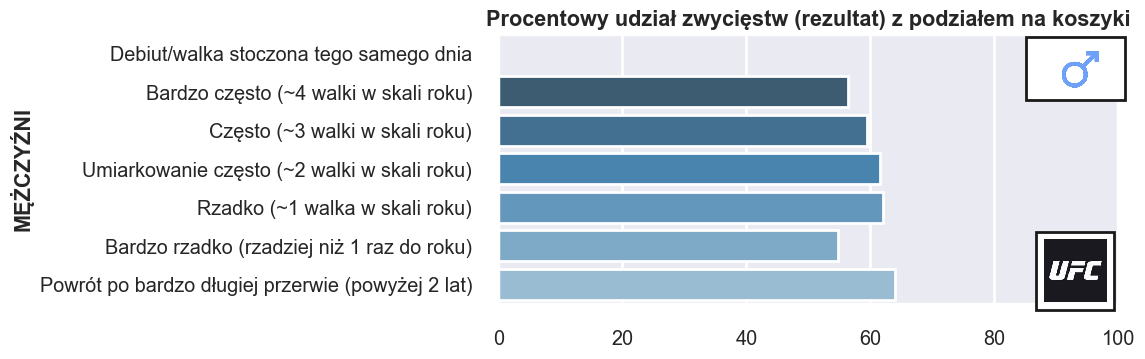

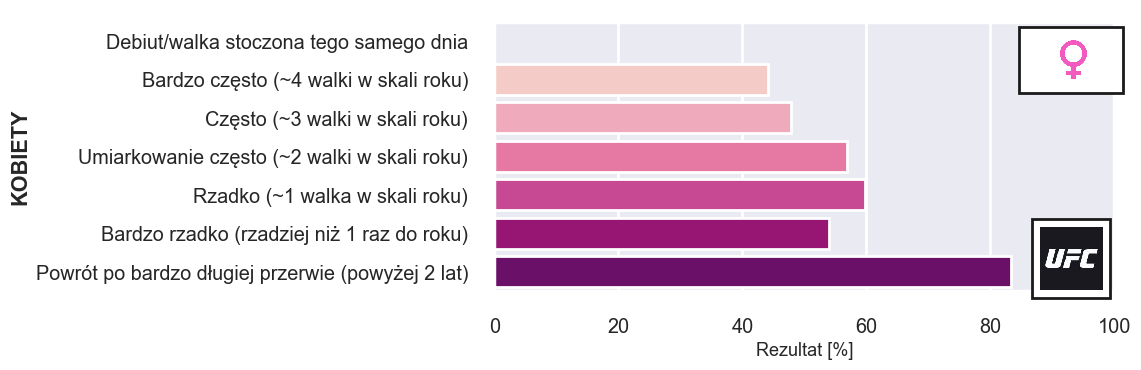

In [451]:
# Zestawienie wykresów z procentowym udziałem zwycięstw dla kobiet i mężczyzn w UFC.
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)

plt.figure(figsize=(8,3.5), dpi= 100)

ax1 = sns.barplot(male_true_pct.values, male_true_pct.index, palette="Blues_d")
ax1.set_xlim(0, 100)
ax1.set_ylabel('MĘŻCZYŹNI', fontweight='heavy')

male_logo = mpimg.imread('male.png')
female_logo = mpimg.imread('female.jpg')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
malebox = OffsetImage(male_logo, zoom=0.2)
ab = AnnotationBbox(imagebox, (93, 5.65))
ab_gen = AnnotationBbox(malebox, (93, 0.4))
ax1.add_artist(ab)
ax1.add_artist(ab_gen)

plt.figure(figsize=(8,3.5), dpi= 100)
ax2 = sns.barplot(female_true_pct, female_true_pct.index, palette="RdPu")
ax2.set_xlim(0, 100)
ax2.set_xlabel('Rezultat [%]', fontsize='smaller')
ax2.set_ylabel('KOBIETY', fontweight='heavy')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
femalebox = OffsetImage(female_logo, zoom=0.075)
ab2 = AnnotationBbox(imagebox, (93, 5.65))
ab_gen2 = AnnotationBbox(femalebox, (93, 0.5))
ax2.add_artist(ab2)
ax2.add_artist(ab_gen2)

ax1.set_title('Procentowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
plt.show()

Analizując dane przez pryzmat podziału na płeć, zaobserwowaliśmy ciekawą dynamikę, zobaczymy czy analizując poszczególne kategorie wagowe, odnotujemy coś interesującego. Czy gabaryty zawodnika mogą wpływać na to, z jaką częstotliwością może on skutecznie walczyć?

W dalszej analizie z podziałem na kategorie wagowe nie będziemy przyglądać się skrajnym koszykom, a więc - **Debiut/walka stoczona tego samego dnia** oraz **Powrót po bardzo długiej przerwie (powyżej 2 lat)**. Jest to podyktowane małą liczbę obserwacji - danym tym przyjrzeliśmy się na etapie analizy całego rostera.

Uwagę skupimy natomiast na najczęściej występujących interwałach, a więc tych z częstotliwościami od 1 do 3 walk w skali roku oraz interwałom - **Bardzo często (~4 walki w skali roku)** i **Bardzo rzadko (rzadziej niż raz do roku)**. Zobaczymy czy uda się zaobserwować jakieś interesujące zależności między kategoriami wagowymi a tym jaki rezultat, został osiągnięty dla poszczególnych koszyków.

### WAGA CIĘŻKA

In [452]:
# Przypisanie obiektu klasy dywizji ciężkiej do zmiennej.
HW_div = weightclass_obj_list[0]

In [453]:
# Sprawdzenie poprawności.
HW_div.name

'Heavyweight'

In [454]:
HW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          107
Rzadko (~1 walka w skali roku)                       100
Często (~3 walki w skali roku)                        68
Bardzo często (~4 walki w skali roku)                 35
Bardzo rzadko (rzadziej niż 1 raz do roku)            26
Powrót po bardzo długiej przerwie (powyżej 2 lat)      5
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [455]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
HW_pct = HW_div.win_fights_counts / (HW_div.win_fights_counts + HW_div.loss_fights_counts)

In [456]:
# Sortowanie w kolejności malejące.
HW_pct_sorted = HW_pct.sort_values(ascending=False)

In [457]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
HW_pct_sorted = HW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                           'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [458]:
HW_pct_sorted

Umiarkowanie często (~2 walki w skali roku)    0.641509
Rzadko (~1 walka w skali roku)                 0.628866
Często (~3 walki w skali roku)                 0.590909
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.576923
Bardzo często (~4 walki w skali roku)          0.575758
Name: Descriptive_interval, dtype: float64

Rozkład procentowy dla wagi ciężkiej niemal w całości pokrywa się z tym, co zaobserwowaliśmy, analizując wszystkich mężczyzn. Ponownie najwyższe rezultaty należą do trzech grup, które uwzględniają częstotliwość walk od 1 do 3 w skali roku - różnice między tymi kategoriami, są podobnie jak w przypadku wszystkich mężczyzn - niewielkie.

Dwa skrajne interwały podobnie jak przy analizie dla wszystkich mężczyzn, osiągnęły najniższy wynik - różnica między interwałem, który osiągnął najlepszy rezultat, a dwoma zamykającymi zestawienie to niecałe *7 punktów procentowych*.

### WAGA PÓŁCIĘŻKA

In [459]:
# Przypisanie obiektu klasy dywizji półciężkiej do zmiennej.
LHW_div = weightclass_obj_list[1]

In [460]:
# Sprawdzenie poprawności.
LHW_div.name

'Light Heavyweight'

In [461]:
LHW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       137
Umiarkowanie często (~2 walki w skali roku)          131
Często (~3 walki w skali roku)                        60
Bardzo często (~4 walki w skali roku)                 50
Bardzo rzadko (rzadziej niż 1 raz do roku)            26
Powrót po bardzo długiej przerwie (powyżej 2 lat)      2
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [462]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
LHW_pct = LHW_div.win_fights_counts / (LHW_div.win_fights_counts + LHW_div.loss_fights_counts)

In [463]:
# Sortowanie w kolejności malejące.
LHW_pct_sorted = LHW_pct.sort_values(ascending=False)

In [464]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
LHW_pct_sorted = LHW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [465]:
LHW_pct_sorted

Bardzo często (~4 walki w skali roku)          0.640000
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.615385
Często (~3 walki w skali roku)                 0.600000
Umiarkowanie często (~2 walki w skali roku)    0.592308
Rzadko (~1 walka w skali roku)                 0.507463
Name: Descriptive_interval, dtype: float64

Dla dywizji półciężkiej obserwujemy odwrotną zależność - dwa graniczne interwały uzyskały najlepszy rezultat. Koszyki reprezentujące częstotliwość od 2 do 3 walk w roku również są procentowo zbliżone. To, co przykuwa jednak uwagę, to **znacząca statystycznie różnica między interwałem reprezentującym częstotliwość 1 walki w skali roku - różnica między nim a koszykiem z najwyższym rezultatem to niemal *14 punktów procentowych***. Warto odnotować, że koszyk ten posiada największą liczbę obserwacji dla tej dywizji, więc nie jest to efektem ubocznym małej liczby obserwacji - nawet porównując go do koszyka z etykietą Umiarkowanie często, obserwujemy około *9 punktów procentowych* różnicy w rezultacie, pomimo że oba koszyki mają praktycznie jednakową liczbę obserwacji.

### WAGA ŚREDNIA

In [466]:
# Przypisanie obiektu klasy dywizji średniej do zmiennej.
MW_div = weightclass_obj_list[2]

In [467]:
# Sprawdzenie poprawności.
MW_div.name

'Middleweight'

In [468]:
MW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          153
Rzadko (~1 walka w skali roku)                       137
Często (~3 walki w skali roku)                        77
Bardzo często (~4 walki w skali roku)                 59
Bardzo rzadko (rzadziej niż 1 raz do roku)            34
Powrót po bardzo długiej przerwie (powyżej 2 lat)      3
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [469]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
MW_pct = MW_div.win_fights_counts / (MW_div.win_fights_counts + MW_div.loss_fights_counts)

In [470]:
# Sortowanie w kolejności malejące.
MW_pct_sorted = MW_pct.sort_values(ascending=False)

In [471]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
MW_pct_sorted = MW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [472]:
MW_pct_sorted

Umiarkowanie często (~2 walki w skali roku)    0.649007
Rzadko (~1 walka w skali roku)                 0.634328
Często (~3 walki w skali roku)                 0.565789
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.531250
Bardzo często (~4 walki w skali roku)          0.474576
Name: Descriptive_interval, dtype: float64

Dla wagi średniej widzimy podobną zależność między rezultatem koszyków, jaka miała miejsce dla wagi ciężkiej i zasadniczo dla populacji mężczyzn. Z tą jednak różnicą, że tutaj najlepszy wynik reprezentują interwały charakteryzujące częstotliwość 1 lub 2 walk w skali roku. Kolejny koszyk, a więc ten reprezentujący częstotliwość 3 walk w skali roku, wypada już o około *7 punktów procentowych* słabiej. 

Skrajne koszyki wypadają najsłabiej w tym zestawieniu, a **koszyk reprezentujący najmniejszą przerwę pomiędzy tocznymi walkami (do 90 dni) osiąga skrajnie niski wynik *47%* i stanowi to ponad *17 punktów procentowych* różnicy względem koszyka z najwyższym rezultatem.**

### WAGA PÓŁŚREDNIA

In [473]:
# Przypisanie obiektu klasy dywizji półśredniej do zmiennej.
WW_div = weightclass_obj_list[3]

In [474]:
# Sprawdzenie poprawności.
WW_div.name

'Welterweight'

In [475]:
WW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          300
Rzadko (~1 walka w skali roku)                       279
Często (~3 walki w skali roku)                       140
Bardzo często (~4 walki w skali roku)                130
Bardzo rzadko (rzadziej niż 1 raz do roku)            63
Powrót po bardzo długiej przerwie (powyżej 2 lat)      8
Debiut/walka stoczona tego samego dnia                 1
Name: Descriptive_interval, dtype: int64

In [476]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
WW_pct = WW_div.win_fights_counts / (WW_div.win_fights_counts + WW_div.loss_fights_counts)

In [477]:
# Sortowanie w kolejności malejące.
WW_pct_sorted = WW_pct.sort_values(ascending=False)

In [478]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
WW_pct_sorted = WW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [479]:
WW_pct_sorted

Rzadko (~1 walka w skali roku)                 0.616487
Umiarkowanie często (~2 walki w skali roku)    0.606780
Bardzo często (~4 walki w skali roku)          0.606299
Często (~3 walki w skali roku)                 0.604317
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.587302
Name: Descriptive_interval, dtype: float64

Dywizja półśrednia charakteryzuje się bardzo małym rozproszeniem rezultatów - pomiędzy koszykiem z najlepszym wynikiem (*Rzadko (~1 walka w skali roku*), a interwałem, który osiągnął najsłabszy rezultat, jest niecałe *3 punkty procentowe* różnicy. Wskazuje to na kompletny brak zależności pomiędzy częstotliwością toczonych walk a osiąganym rezultatem dla omawianej grupy.

### WAGA LEKKA

In [480]:
# Przypisanie obiektu klasy dywizji lekkiej do zmiennej.
LW_div = weightclass_obj_list[4]

In [481]:
# Sprawdzenie poprawności.
LW_div.name

'Lightweight'

In [482]:
LW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          285
Rzadko (~1 walka w skali roku)                       266
Często (~3 walki w skali roku)                       148
Bardzo często (~4 walki w skali roku)                130
Bardzo rzadko (rzadziej niż 1 raz do roku)            48
Powrót po bardzo długiej przerwie (powyżej 2 lat)     10
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [483]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
LW_pct = LW_div.win_fights_counts / (LW_div.win_fights_counts + LW_div.loss_fights_counts)

In [484]:
# Sortowanie w kolejności malejące.
LW_pct_sorted = LW_pct.sort_values(ascending=False)

In [485]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
LW_pct_sorted = LW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [486]:
LW_pct_sorted

Bardzo rzadko (rzadziej niż 1 raz do roku)     0.659574
Rzadko (~1 walka w skali roku)                 0.647287
Umiarkowanie często (~2 walki w skali roku)    0.607774
Często (~3 walki w skali roku)                 0.584507
Bardzo często (~4 walki w skali roku)          0.561538
Name: Descriptive_interval, dtype: float64

**Bardzo ciekawie prezentują się wyniki dla dywizji lekkiej - wygląda na to, że im mniejsza częstotliwość, tym lepszy rezultat.** O ile dla interwałów charakteryzujących częstotliwość rzadszą niż raz do roku oraz jednej walki w skali roku, rezultaty są zbliżone, tak kolejne koszyki wypadają już słabej o przynajmniej *5 punktów procentowych*. Różnica rezultatów zawodników, którzy do walki przystąpili po ponad rocznej przerwie, a zawodników, którzy odczekali, nie więcej niż 90 dni wynosi w przypadku wagi lekkiej prawie *10 punktów procentowych*.

### WAGA PIÓRKOWA

In [487]:
# Przypisanie obiektu klasy dywizji piórkowej do zmiennej.
FW_div = weightclass_obj_list[5]

In [488]:
# Sprawdzenie poprawności.
FW_div.name

'Featherweight'

In [489]:
FW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          174
Rzadko (~1 walka w skali roku)                       156
Często (~3 walki w skali roku)                        62
Bardzo często (~4 walki w skali roku)                 57
Bardzo rzadko (rzadziej niż 1 raz do roku)            50
Powrót po bardzo długiej przerwie (powyżej 2 lat)      6
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [490]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
FW_pct = FW_div.win_fights_counts / (FW_div.win_fights_counts + FW_div.loss_fights_counts)

In [491]:
# Sortowanie w kolejności malejące.
FW_pct_sorted = LW_pct.sort_values(ascending=False)

In [492]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
FW_pct_sorted = FW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [493]:
FW_pct_sorted

Bardzo rzadko (rzadziej niż 1 raz do roku)     0.659574
Rzadko (~1 walka w skali roku)                 0.647287
Umiarkowanie często (~2 walki w skali roku)    0.607774
Często (~3 walki w skali roku)                 0.584507
Bardzo często (~4 walki w skali roku)          0.561538
Name: Descriptive_interval, dtype: float64

Analiza dla dywizji piórkowej potwierdza zależności zaobserwowane podczas inspekcji dywizji lekkiej - mniejsza intensywność sprzyja lepszym rezultatom. Tutaj również najsłabiej wypadają zawodnicy, którzy do swojej następnej walki zdecydowali się czekać nie dłużej niż 90 dni. Podobnie jak w przypadku wagi lekkiej różnica między tymi interwałami wynosi niemal *10 punktów procentowych*.

### WAGA KOGUCIA

In [494]:
# Przypisanie obiektu klasy dywizji koguciej do zmiennej.
BW_div = weightclass_obj_list[6]

In [495]:
# Sprawdzenie poprawności.
BW_div.name

'Bantamweight'

In [496]:
BW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       157
Umiarkowanie często (~2 walki w skali roku)          147
Często (~3 walki w skali roku)                        68
Bardzo często (~4 walki w skali roku)                 59
Bardzo rzadko (rzadziej niż 1 raz do roku)            34
Powrót po bardzo długiej przerwie (powyżej 2 lat)      5
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [497]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
BW_pct = BW_div.win_fights_counts / (BW_div.win_fights_counts + BW_div.loss_fights_counts)

In [498]:
# Sortowanie w kolejności malejące.
BW_pct_sorted = BW_pct.sort_values(ascending=False)

In [499]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
BW_pct_sorted = BW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [500]:
BW_pct_sorted

Często (~3 walki w skali roku)                 0.632353
Umiarkowanie często (~2 walki w skali roku)    0.631944
Rzadko (~1 walka w skali roku)                 0.606452
Bardzo często (~4 walki w skali roku)          0.593220
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.333333
Name: Descriptive_interval, dtype: float64

Dla dywizji koguciej najlepszy rezultat osiągnęły interwały obrazujące częstotliwość 3 walk w skali roku oraz 2. Koszyki z częstotliwością 1 walki w skali roku oraz 4 walk również osiągnęły zbliżone rezultaty. **Grupa walcząca rzadziej niż raz do roku uzyskała jak dotychczas najniższy procentowy rezultat ze wszystkich dywizji wagowych - *33%***. Liczba obserwacji dla tej grupy wyniosła 34.

### WAGA MUSZA

In [501]:
# Przypisanie obiektu klasy dywizji muszej do zmiennej.
FLW_div = weightclass_obj_list[7]

In [502]:
# Sprawdzenie poprawności.
FLW_div.name

'Flyweight'

In [503]:
FLW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       75
Umiarkowanie często (~2 walki w skali roku)          68
Często (~3 walki w skali roku)                       29
Bardzo często (~4 walki w skali roku)                22
Bardzo rzadko (rzadziej niż 1 raz do roku)           10
Powrót po bardzo długiej przerwie (powyżej 2 lat)     0
Debiut/walka stoczona tego samego dnia                0
Name: Descriptive_interval, dtype: int64

In [504]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
FLW_pct = FLW_div.win_fights_counts / (FLW_div.win_fights_counts + FLW_div.loss_fights_counts)

In [505]:
# Sortowanie w kolejności malejące.
FLW_pct_sorted = FLW_pct.sort_values(ascending=False)

In [506]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
FLW_pct_sorted = FLW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [507]:
FLW_pct_sorted

Rzadko (~1 walka w skali roku)                 0.680000
Umiarkowanie często (~2 walki w skali roku)    0.558824
Bardzo często (~4 walki w skali roku)          0.500000
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.444444
Często (~3 walki w skali roku)                 0.428571
Name: Descriptive_interval, dtype: float64

Dywizja musza charakteryzuje się najmniejszą liczbą obserwacji, co wpłynęło na rezultat - dane są bardziej rozproszone niż dla innych dywizji i widzimy relatywnie duże różnice procentowe pomiędzy koszykami. Najlepszy rezultat osiągnęły interwały opisujące częstotliwość od 1 do 2 walk w skali roku. Najsłabsze wyniki to z kolei koszyk reprezentujący częstotliwość 3 walk w skali roku oraz ten, gdzie przerwa między walkami wyniosła więcej niż rok.

### Wizualizacje dla wszystkich dywizji wagowych mężczyzn

In [508]:
# Okrojenie wyników dla danych podsumowujących mężczyzn w UFC w celu wizualizacji z poszczególnymi dywizjami wagowymi.
male_pct_trunc = male_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [509]:
male_pct_trunc

Rzadko (~1 walka w skali roku)                 0.619455
Umiarkowanie często (~2 walki w skali roku)    0.616012
Często (~3 walki w skali roku)                 0.594679
Bardzo często (~4 walki w skali roku)          0.564246
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.547368
Name: Descriptive_interval, dtype: float64

In [510]:
# Utworzenie obiektów DataFrame na potrzeby wizualizacji wyników.
HW_frame = pd.DataFrame(dict(HEAVYWEIGHT = HW_pct_sorted, MALE = male_pct_trunc))
LHW_frame = pd.DataFrame(dict(LIGHT_HEAVYWEIGHT = LHW_pct_sorted, MALE = male_pct_trunc))
MW_frame = pd.DataFrame(dict(MIDDLEWEIGHT = MW_pct_sorted, MALE = male_pct_trunc))
WW_frame = pd.DataFrame(dict(WALTERWEIGHT = WW_pct_sorted, MALE = male_pct_trunc))
LW_frame = pd.DataFrame(dict(LIGHTWEIGHT = LW_pct_sorted, MALE = male_pct_trunc))
FW_frame = pd.DataFrame(dict(FEATHERWEIGHT = FW_pct_sorted, MALE = male_pct_trunc))
BW_frame = pd.DataFrame(dict(BANTAMWEIGHT = BW_pct_sorted, MALE = male_pct_trunc))
FLW_frame = pd.DataFrame(dict(FLYWEIGHT = FLW_pct_sorted, MALE = male_pct_trunc))

In [511]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji
new_index = ['Bardzo często (~4 walki w skali roku)', 'Często (~3 walki w skali roku)', 
             'Umiarkowanie często (~2 walki w skali roku)', 'Rzadko (~1 walka w skali roku)',
             'Bardzo rzadko (rzadziej niż 1 raz do roku)']

HW_frame = HW_frame.reindex(index=new_index)
LHW_frame = LHW_frame.reindex(index=new_index)
MW_frame = MW_frame.reindex(index=new_index)
WW_frame = WW_frame.reindex(index=new_index)
LW_frame = LW_frame.reindex(index=new_index)
FW_frame = FW_frame.reindex(index=new_index)
BW_frame = BW_frame.reindex(index=new_index)
FLW_frame = FLW_frame.reindex(index=new_index)

In [512]:
# Funkcja pomocnicza inicjująca wykresy porównujące rezultat kategorii wagowych z populacją płci.

def create_div_barplot(div_frame, gender):
    '''
    args: DataFrame obj, 
          gender as string: F for female, or M for men
    '''
    plt.rcdefaults()
    if gender == 'M':
        with plt.style.context('seaborn'):
            plt.figure(figsize=(18, 9), dpi=100)
            ax = div_frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=['k', 'b'])

            imagebox = OffsetImage(ufc_logo, zoom=0.25)
            malebox = OffsetImage(male_logo, zoom=0.2)
            ab = AnnotationBbox(imagebox, (0, 0.91))
            ab_gen = AnnotationBbox(malebox, (0.75, 0.92))
            ax.add_artist(ab)
            ax.add_artist(ab_gen)

            plt.title('Ułamkowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
            plt.legend(frameon=True, shadow=True)
            plt.show()
    elif gender == 'F':
        with plt.style.context('seaborn'):
            plt.figure(figsize=(18, 9), dpi=100)
            ax = div_frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=['k', 'fuchsia'])

            imagebox = OffsetImage(ufc_logo, zoom=0.25)
            femalebox = OffsetImage(female_logo, zoom=0.071)
            ab = AnnotationBbox(imagebox, (0, 0.91))
            ab_gen = AnnotationBbox(femalebox, (0.75, 0.92))
            ax.add_artist(ab)
            ax.add_artist(ab_gen)

            plt.title('Ułamkowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
            plt.legend(frameon=True, shadow=True)
            plt.show()
    else:
        print('Gender was not specyfied in the function!')

<Figure size 1800x900 with 0 Axes>

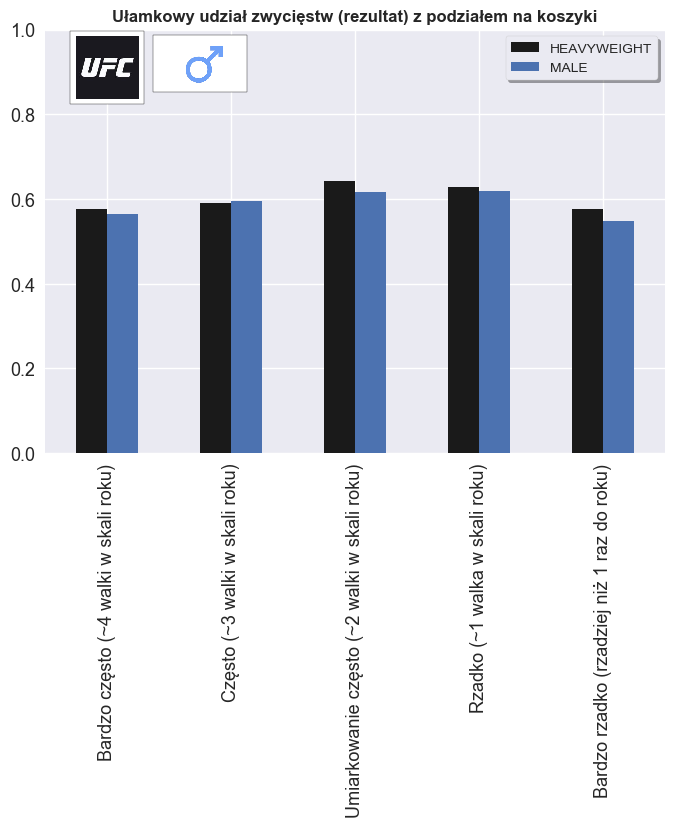

In [513]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze ciężkiej oraz dla populacji mężczyzn.
create_div_barplot(HW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

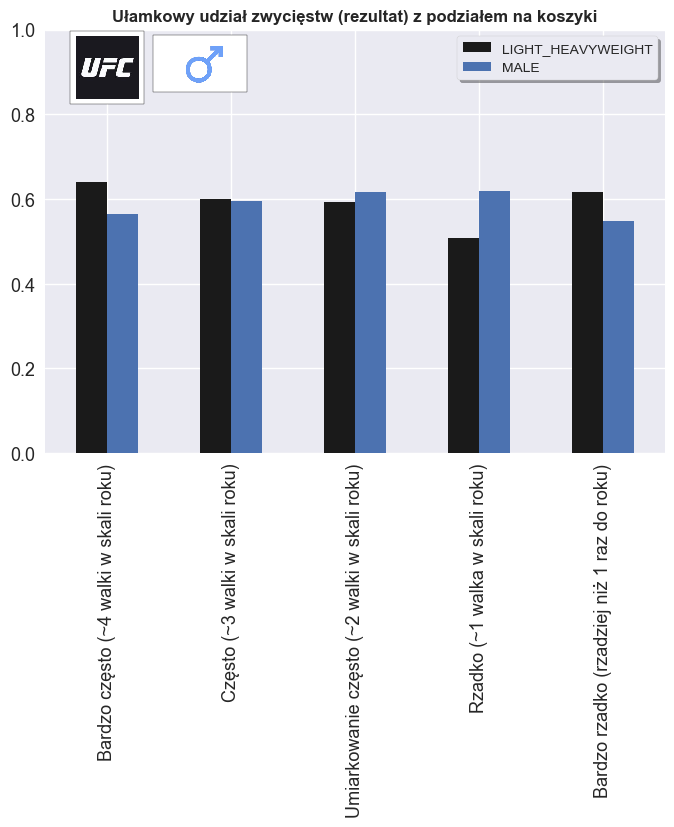

In [514]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze półciężkiej oraz dla populacji mężczyzn.
create_div_barplot(LHW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

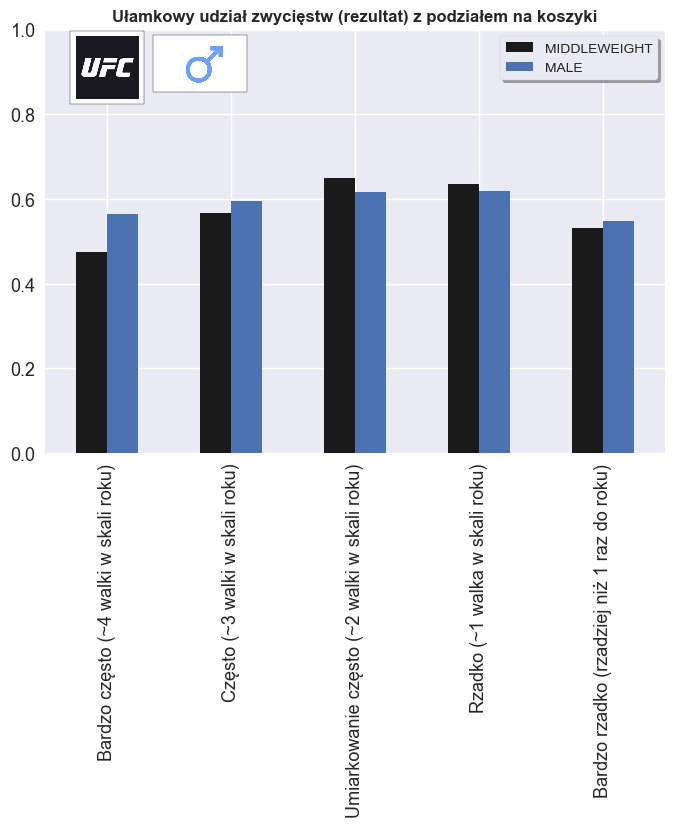

In [515]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze średniej oraz dla populacji mężczyzn.
create_div_barplot(MW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

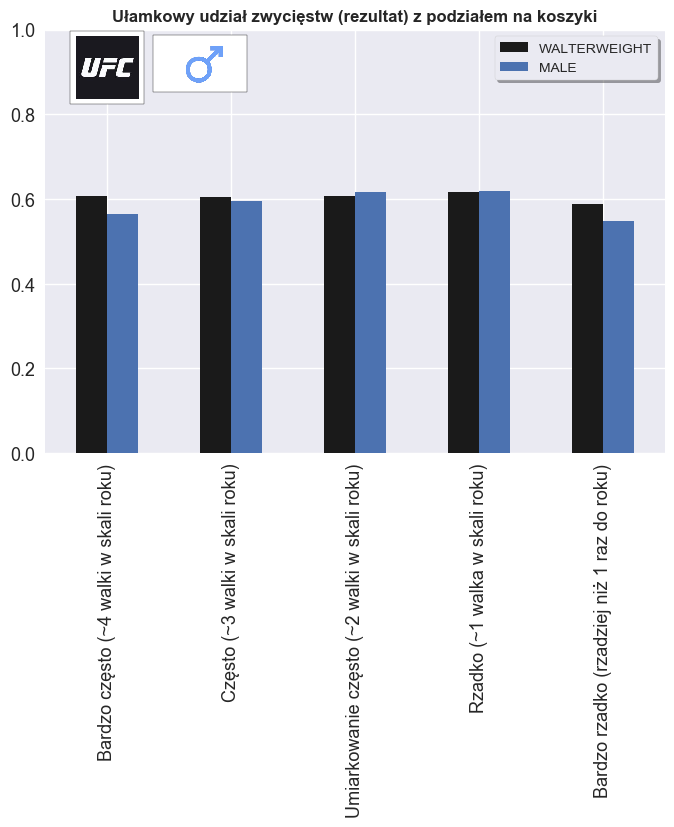

In [516]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze półśredniej oraz dla populacji mężczyzn.
create_div_barplot(WW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

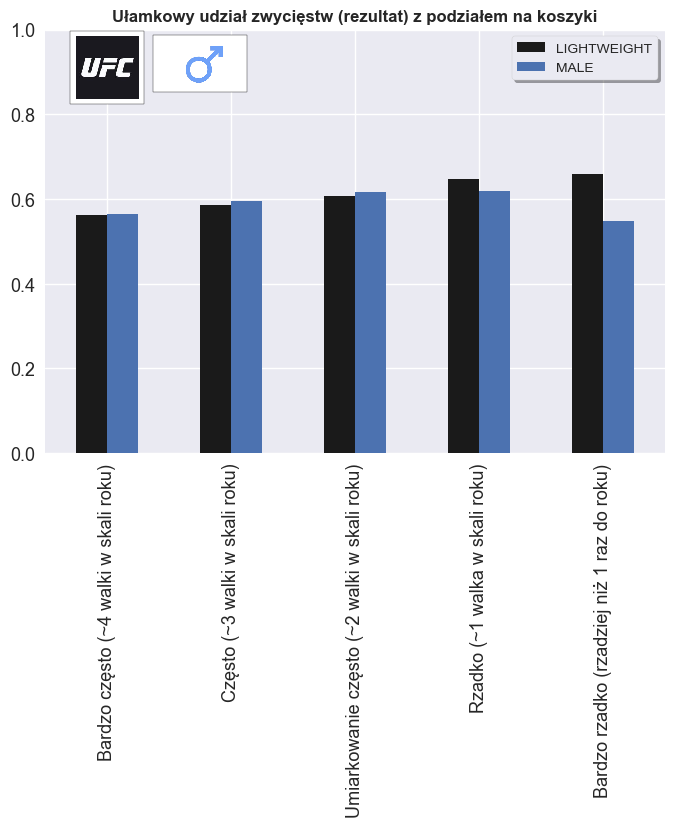

In [517]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze lekkiej oraz dla populacji mężczyzn.
create_div_barplot(LW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

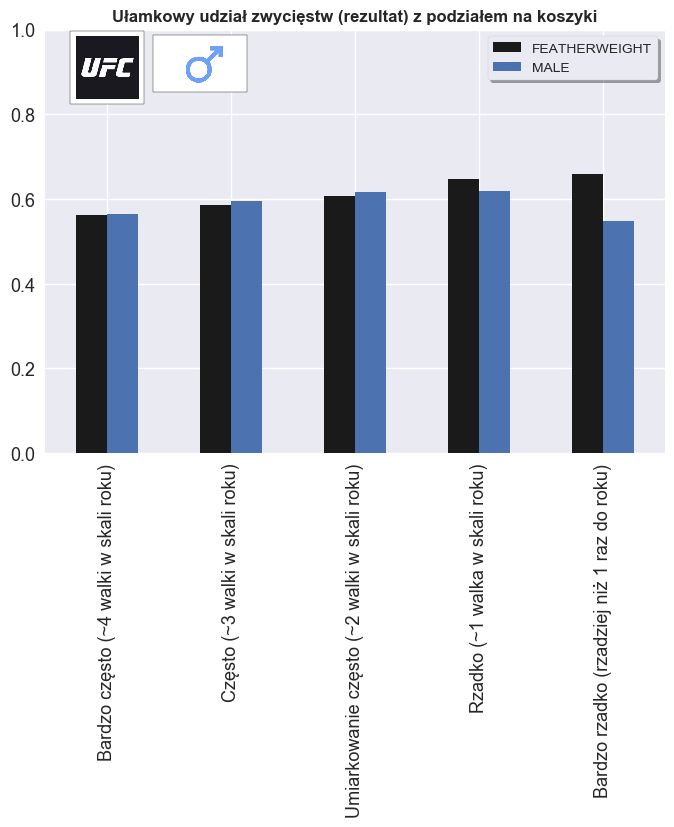

In [518]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze piórkowej oraz dla populacji mężczyzn.
create_div_barplot(FW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

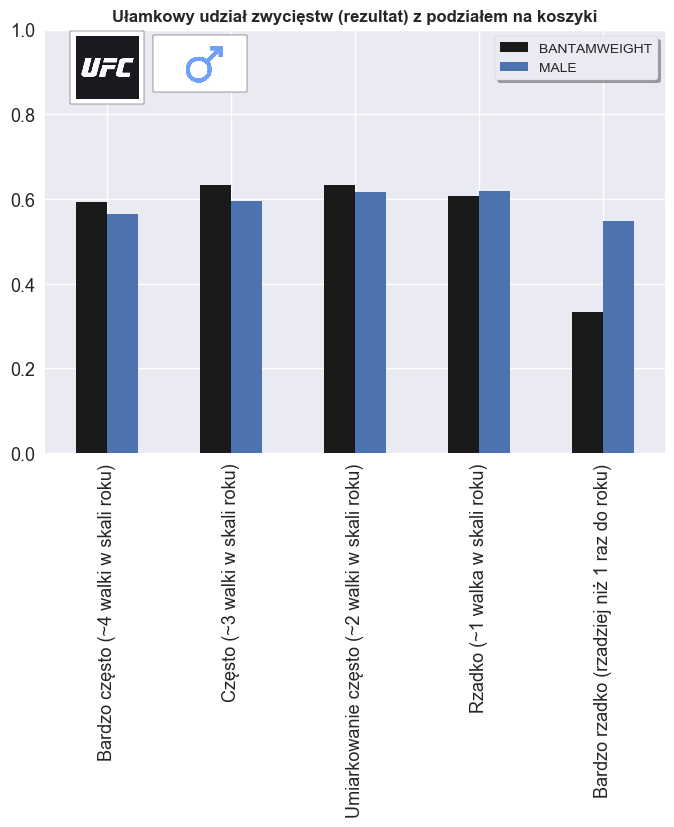

In [519]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze koguciej oraz dla populacji mężczyzn.
create_div_barplot(BW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

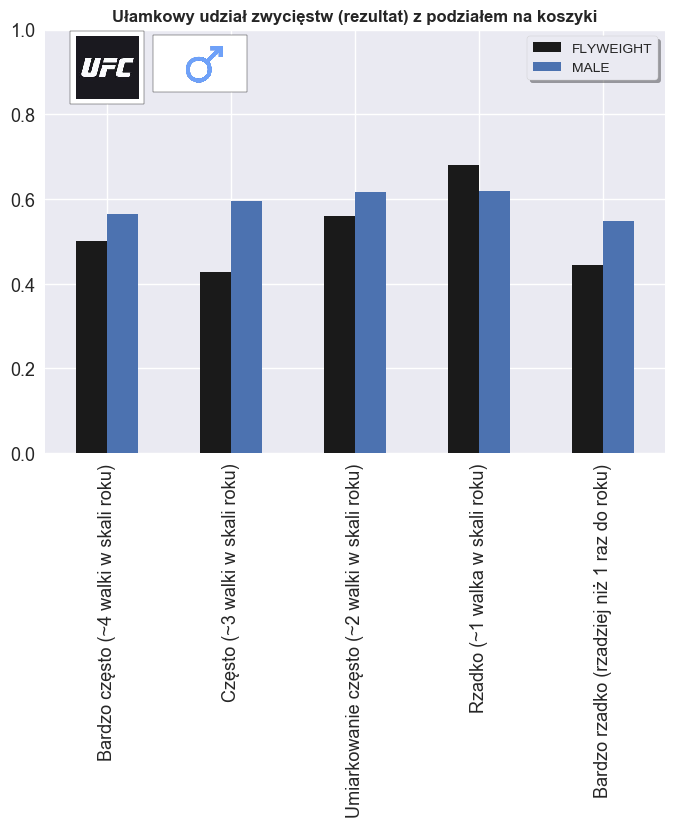

In [520]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze muszej oraz dla populacji mężczyzn.
create_div_barplot(FLW_frame, 'M')

### WAGA SŁOMKOWA KOBIET

In [521]:
# Przypisanie obiektu klasy dywizji słomkowej kobiet do zmiennej.
WSW_div = weightclass_obj_list[8]

In [522]:
# Sprawdzenie poprawności.
WSW_div.name

"Women's Strawweight"

In [523]:
WSW_div.all_fights_counts

Umiarkowanie często (~2 walki w skali roku)          75
Rzadko (~1 walka w skali roku)                       69
Często (~3 walki w skali roku)                       36
Bardzo rzadko (rzadziej niż 1 raz do roku)           23
Bardzo często (~4 walki w skali roku)                20
Powrót po bardzo długiej przerwie (powyżej 2 lat)     3
Debiut/walka stoczona tego samego dnia                0
Name: Descriptive_interval, dtype: int64

In [524]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
WSW_pct = WSW_div.win_fights_counts / (WSW_div.win_fights_counts + WSW_div.loss_fights_counts)

In [525]:
# Sortowanie w kolejności malejące.
WSW_pct_sorted = WSW_pct.sort_values(ascending=False)

In [526]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
WSW_pct_sorted = WSW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [527]:
WSW_pct_sorted

Bardzo rzadko (rzadziej niż 1 raz do roku)     0.652174
Umiarkowanie często (~2 walki w skali roku)    0.560000
Bardzo często (~4 walki w skali roku)          0.555556
Rzadko (~1 walka w skali roku)                 0.536232
Często (~3 walki w skali roku)                 0.500000
Name: Descriptive_interval, dtype: float64

W przypadku dywizji słomkowej pozytywnie wyróżnił się interwał o częstotliwości - bardzo rzadko, uzyskując wynik o niemal *10 punktów procentowych* wyższy od pozostałych koszyków. Dalsze różnice między kategoriami nie były już tak znaczące i rozpiętość zmian między drugim koszykiem z najwyższym rezultatem a ostatnim wyniosła *6 punktów procentowych*.

### WAGA MUSZA KOBIET

In [528]:
# Przypisanie obiektu klasy dywizji muszej kobiet do zmiennej.
WFLW_div = weightclass_obj_list[9]

In [529]:
# Sprawdzenie poprawności.
WFLW_div.name

"Women's Flyweight"

In [530]:
WFLW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       64
Umiarkowanie często (~2 walki w skali roku)          56
Często (~3 walki w skali roku)                       22
Bardzo rzadko (rzadziej niż 1 raz do roku)           19
Bardzo często (~4 walki w skali roku)                12
Powrót po bardzo długiej przerwie (powyżej 2 lat)     1
Debiut/walka stoczona tego samego dnia                0
Name: Descriptive_interval, dtype: int64

In [531]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
WFLW_pct = WFLW_div.win_fights_counts / (WFLW_div.win_fights_counts + WFLW_div.loss_fights_counts)

In [532]:
# Sortowanie w kolejności malejące.
WFLW_pct_sorted = WFLW_pct.sort_values(ascending=False)

In [533]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
WFLW_pct_sorted = WFLW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [534]:
WFLW_pct_sorted

Rzadko (~1 walka w skali roku)                 0.625000
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.526316
Umiarkowanie często (~2 walki w skali roku)    0.509091
Często (~3 walki w skali roku)                 0.454545
Bardzo często (~4 walki w skali roku)          0.250000
Name: Descriptive_interval, dtype: float64

W dywizji muszej kobiet zdecydowanie najlepszy rezultat osiągnął interwał opisujący przybliżoną częstotliwość 1 walki w skali roku. Uzyskał on około *10 punktów procentowych* lepszy rezultat, aniżeli kolejny koszyk odwołujący się do częstotliwości rzadszej niż raz do roku. Dwa najgorsze rezultaty przypadły koszykom o wysokiej częstotliwości toczonych walk. Wyniki te pokrywają się z obserwacjami dokonanymi dla całej populacji kobiet w UFC.

### WAGA KOGUCIA KOBIET

In [535]:
# Przypisanie obiektu klasy dywizji koguciej kobiet do zmiennej.
WBW_div = weightclass_obj_list[10]

In [536]:
# Sprawdzenie poprawności.
WBW_div.name

"Women's Bantamweight"

In [537]:
WBW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       56
Umiarkowanie często (~2 walki w skali roku)          38
Bardzo rzadko (rzadziej niż 1 raz do roku)           15
Bardzo często (~4 walki w skali roku)                11
Często (~3 walki w skali roku)                        9
Powrót po bardzo długiej przerwie (powyżej 2 lat)     2
Debiut/walka stoczona tego samego dnia                0
Name: Descriptive_interval, dtype: int64

In [538]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
WBW_pct = WBW_div.win_fights_counts / (WBW_div.win_fights_counts + WBW_div.loss_fights_counts)

In [539]:
# Sortowanie w kolejności malejące.
WBW_pct_sorted = WBW_pct.sort_values(ascending=False)

In [540]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
WBW_pct_sorted = WBW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [541]:
WBW_pct_sorted

Umiarkowanie często (~2 walki w skali roku)    0.675676
Rzadko (~1 walka w skali roku)                 0.625000
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.466667
Bardzo często (~4 walki w skali roku)          0.454545
Często (~3 walki w skali roku)                 0.375000
Name: Descriptive_interval, dtype: float64

Wyniki dla dywizji koguciej kobiet nie odbiegają znacząco od tego, co zaobserwowaliśmy w dywizji muszej. Najlepsze rezultaty ponownie przypadły interwałom z mniejszą częstotliwością - interwał 2 walk w skali roku uzyskał najlepszy rezultat, wyprzedzając interwał odpowiadający jednej walce w skali roku. Koszyk opisujący aktywność rzadszą niż raz do roku uzyskał tutaj jednak znacznie słabszy rezultat. Najsłabiej pod tym względem ponownie wypadły koszyki odwołujące się do interwałów o dużej częstotliwości. 

### WAGA PIÓRKOWA KOBIET

In [542]:
# Przypisanie obiektu klasy dywizji piórkowej kobiet do zmiennej.
WFW_div = weightclass_obj_list[11]

In [543]:
# Sprawdzenie poprawności.
WFW_div.name

"Women's Featherweight"

In [544]:
WFW_div.all_fights_counts

Rzadko (~1 walka w skali roku)                       7
Umiarkowanie często (~2 walki w skali roku)          7
Bardzo rzadko (rzadziej niż 1 raz do roku)           6
Bardzo często (~4 walki w skali roku)                2
Często (~3 walki w skali roku)                       1
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0
Debiut/walka stoczona tego samego dnia               0
Name: Descriptive_interval, dtype: int64

In [545]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
WFW_pct = WFW_div.win_fights_counts / (WFW_div.win_fights_counts + WFW_div.loss_fights_counts)

In [546]:
# Sortowanie w kolejności malejące.
WFW_pct_sorted = WFW_pct.sort_values(ascending=False)

In [547]:
# Usunięcie wyników dla dwóch koszyków zgodnie z założeniami dalszej analizy.
WFW_pct_sorted = WFW_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [548]:
WFW_pct_sorted

Często (~3 walki w skali roku)                 1.000000
Rzadko (~1 walka w skali roku)                 0.714286
Umiarkowanie często (~2 walki w skali roku)    0.571429
Bardzo często (~4 walki w skali roku)          0.500000
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.333333
Name: Descriptive_interval, dtype: float64

Waga piórkowa kobiet niestety nie obfituje w mnogość obserwacji i przy tak niskiej liczbie rekordów obserwujemy dużą fluktuację danych.

### Wizualizacje dla wszystkich dywizji wagowych kobiet

In [549]:
# Okrojenie wyników dla danych podsumowujących mężczyzn w UFC w celu wizualizacji z poszczególnymi dywizjami wagowymi.
female_pct_trunc = female_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia', 
                                             'Powrót po bardzo długiej przerwie (powyżej 2 lat)'])

In [550]:
female_pct_trunc

Rzadko (~1 walka w skali roku)                 0.596939
Umiarkowanie często (~2 walki w skali roku)    0.568966
Bardzo rzadko (rzadziej niż 1 raz do roku)     0.539683
Często (~3 walki w skali roku)                 0.477612
Bardzo często (~4 walki w skali roku)          0.441860
Name: Descriptive_interval, dtype: float64

In [551]:
# Utworzenie obiektów DataFrame na potrzeby wizualizacji wyników.
WSW_frame = pd.DataFrame(dict(STRAWWEIGHT = WSW_pct_sorted, FEMALE = female_pct_trunc))
WFLW_frame = pd.DataFrame(dict(FLYWEIGHT = WFLW_pct_sorted, FEMALE = female_pct_trunc))
WBW_frame = pd.DataFrame(dict(BANTAMWEIGHT = WBW_pct_sorted, FEMALE = female_pct_trunc))
WFW_frame = pd.DataFrame(dict(FEATHERWEIGHT = WFW_pct_sorted, FEMALE = female_pct_trunc))

In [552]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji
WSW_frame = WSW_frame.reindex(index=new_index)
WFLW_frame = WFLW_frame.reindex(index=new_index)
WBW_frame = WBW_frame.reindex(index=new_index)
WFW_frame = WFW_frame.reindex(index=new_index)

<Figure size 1800x900 with 0 Axes>

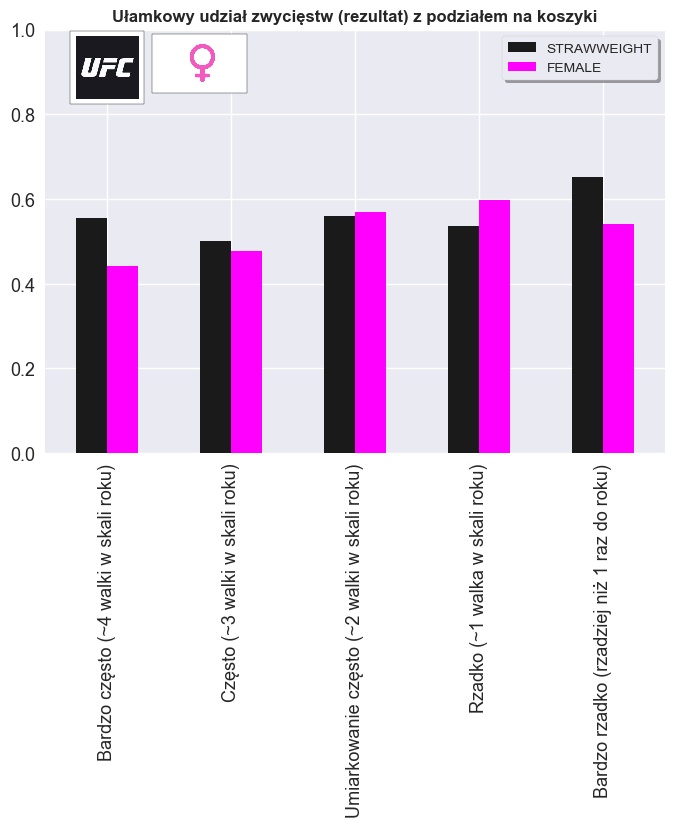

In [553]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze słomkowej oraz dla populacji kobiet.
create_div_barplot(WSW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

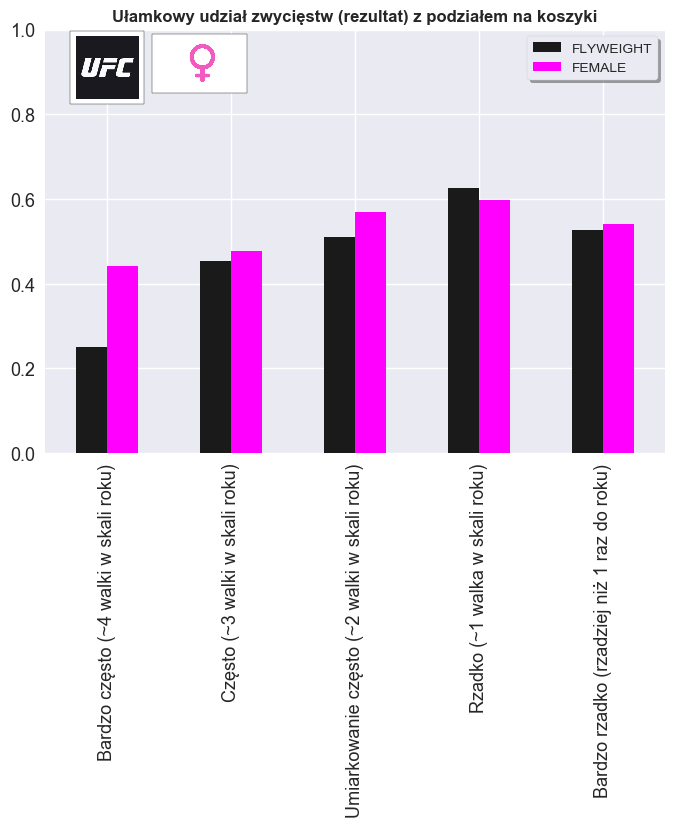

In [554]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze muszej oraz dla populacji kobiet.
create_div_barplot(WFLW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

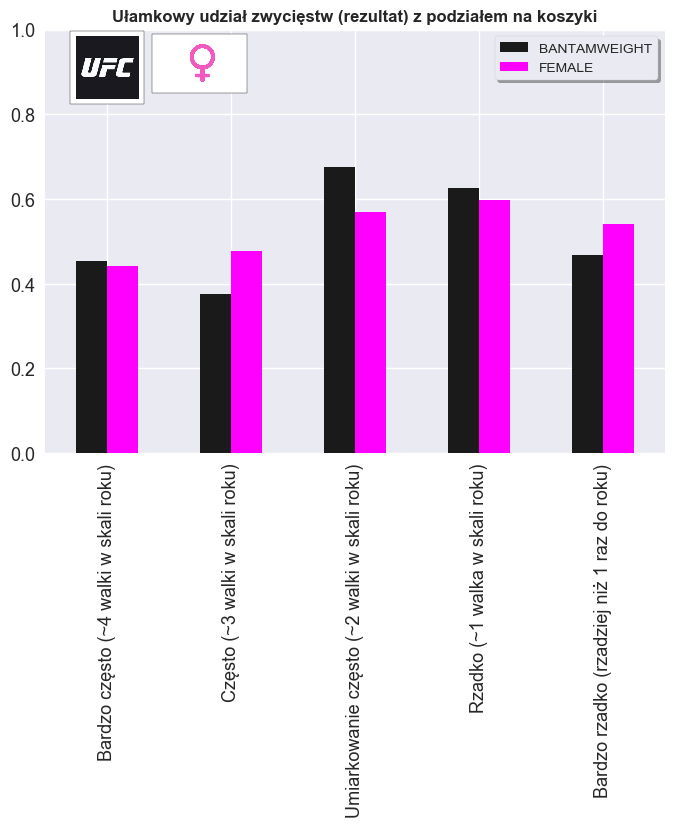

In [555]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze koguciej oraz dla populacji kobiet.
create_div_barplot(WBW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

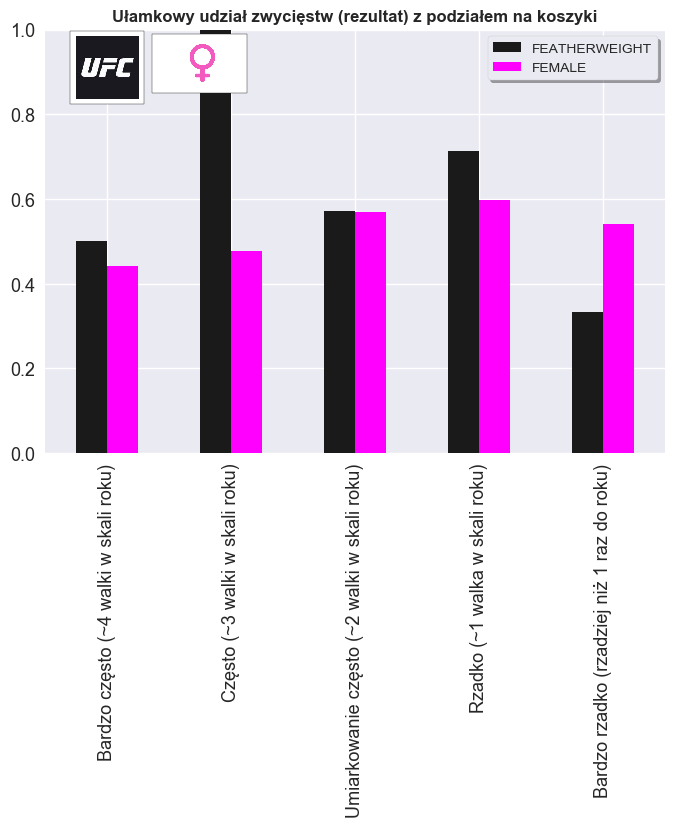

In [556]:
# Wykres porównujący rezultat uzyskany dla wybranych koszyków w wadze piórkowej oraz dla populacji kobiet.
create_div_barplot(WFW_frame, 'F')

## Segment 5: *Dalsza analiza zebranych danych - uwzględnienie okoliczności specjalnych*

W pierwszej części spróbujemy zweryfikować hipotezę mówiącą, że zawodnik po przegranej przez nokaut powinien dla własnego dobra wziąć dłuższą przerwę - pominiemy tutaj aspekt zdrowotny czy psychiczny tego rozwiązania i skupimy się tylko i wyłącznie na tym, czy istnieje relacja pomiędzy czasem, w jakim zawodnik wraca po porażce przez nokaut, a jego procentową szansą na odniesienie zwycięstwa w tymże powrocie. 

Weźmy pod lupę zawodników rostera UFC - zobaczymy czy wyżej wymienioną hipotezę da się potwierdzić dla elitarnych zawodników MMA.

In [557]:
ufc_selected_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku)
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Rzadko (~1 walka w skali roku)
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku)


In [558]:
ufc_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time
0,Shamil Abdurakhimov,Curtis Blaydes,loss,UFC 242 - Khabib vs. Poirier,Sep / 07 / 2019,TKO (Elbow and Punch),Marc Goddard,2,02:22
1,Shamil Abdurakhimov,Marcin Tybura,win,UFC Fight Night 149 - Overeem vs. Oleynik,Apr / 20 / 2019,TKO (Punches),Herb Dean,2,03:15
2,Shamil Abdurakhimov,Andrei Arlovski,win,UFC Fight Night 136 - Hunt vs. Oleynik,Sep / 15 / 2018,Decision (Unanimous),Leon Roberts,3,05:00
3,Shamil Abdurakhimov,Chase Sherman,win,UFC Fight Night 122 - Bisping vs. Gastelum,Nov / 25 / 2017,KO (Punches),Steve Perceval,1,01:24
4,Shamil Abdurakhimov,Derrick Lewis,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,Dec / 09 / 2016,TKO (Punches),Dan Miragliotta,4,03:42
5,Shamil Abdurakhimov,Walt Harris,win,UFC Fight Night 96 - Lineker vs. Dodson,Oct / 01 / 2016,Decision (Split),Herb Dean,3,05:00
6,Shamil Abdurakhimov,Anthony Hamilton,win,UFC Fight Night 83 - Cerrone vs. Oliveira,Feb / 21 / 2016,Decision (Unanimous),Chip Snider,3,05:00
7,Shamil Abdurakhimov,Timothy Johnson,loss,UFC Fight Night 63 - Mendes vs. Lamas,Apr / 04 / 2015,TKO (Punches),Mike King,1,04:57
8,Shamil Abdurakhimov,Kenny Garner,win,M-1 Challenge 49 - Battle in the Mountains,Jun / 07 / 2014,Decision (Unanimous),Viktor Korneev,3,05:00
9,Shamil Abdurakhimov,Neil Grove,win,Tech-Krep FC - Southern Front 2,Oct / 04 / 2013,Decision (Unanimous),Ashot Ashughyan,3,05:00


In [559]:
# Tworzymy nową zmienną przechowującą kopię DataFrame'u zawodników rostera UFC.
ufc_extra_data = ufc_selected_data.copy()

In [560]:
# Dodajemy dwie dodatkowe kolumny, które będą nam konieczne do przeprowadzenia tej i kolejnej analizy.
ufc_extra_data['Method'] = ufc_data['Method']
ufc_extra_data['Round'] = ufc_data['Round']

In [561]:
ufc_extra_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku),TKO (Elbow and Punch),2
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku),TKO (Punches),2
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku),KO (Punches),1
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku),TKO (Punches),4
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku),Decision (Split),3
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku),TKO (Punches),1
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku),Decision (Unanimous),3


In [562]:
# Użycie maski w celu odsortowania jedynie rekordów, które spełniają warunki analizy i przypisanie wyników nowej zmiennej.
ufc_after_ko = ufc_extra_data[(ufc_extra_data['Result'].shift(-1) == 'loss') & 
                              (ufc_extra_data['Method'].shift(-1).str.contains('KO')) & 
                              (ufc_extra_data['Fighter'] == ufc_extra_data['Fighter'].shift(-1))].copy()

In [563]:
ufc_after_ko[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku),KO (Punches),1
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
33,Klidson Abreu,win,JF - Jungle Fight 90,2016-09-03,105,Często (~3 walki w skali roku),TKO (Doctor Stoppage),3
36,Klidson Abreu,win,SFC 1 - Sierra Fighting Championship 1,2015-08-22,252,Rzadko (~1 walka w skali roku),TKO (Punches),1
78,Kevin Aguilar,win,LFC 39 - Legacy Fighting Championship 39,2015-02-27,448,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Punches),3
92,Omari Akhmedov,win,UFC Fight Night 101 - Whittaker vs. Brunson,2016-11-26,224,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
93,Omari Akhmedov,loss,UFC on Fox 19 - Teixeira vs. Evans,2016-04-16,128,Umiarkowanie często (~2 walki w skali roku),TKO (Knees and Punches),3
122,Heili Alateng,win,Road FC 46 - Road Fighting Championship 46,2018-03-10,364,Rzadko (~1 walka w skali roku),TKO (Punches),1
134,Heili Alateng,loss,CKFC - Chinese Kung Fu Championships,2014-12-23,37,Bardzo często (~4 walki w skali roku),Decision (Unanimous),3
136,Heili Alateng,win,CKFC - Chinese Kung Fu Championships,2014-11-11,157,Umiarkowanie często (~2 walki w skali roku),Submission (Rear-Naked Choke),2


In [564]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej.
ufc_ko_brackets = ufc_after_ko['Descriptive_interval']

In [565]:
# Utworzenie zmiennych gdzie przechowywane będą sumaryczna ilość walk dla poszczególnych kryteriów.
ufc_ako_all_fights_count = ufc_ko_brackets.value_counts()
ufc_ako_win_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'win'].value_counts()
ufc_ako_loss_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'loss'].value_counts()
ufc_ako_draw_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'draw'].value_counts()
ufc_ako_nc_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'NC'].value_counts()

In [566]:
ufc_ako_all_fights_count

Rzadko (~1 walka w skali roku)                       268
Umiarkowanie często (~2 walki w skali roku)          208
Bardzo często (~4 walki w skali roku)                 84
Często (~3 walki w skali roku)                        70
Bardzo rzadko (rzadziej niż 1 raz do roku)            69
Powrót po bardzo długiej przerwie (powyżej 2 lat)     16
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [567]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
ufc_after_ko[ufc_after_ko['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round


In [568]:
# Weryfikacja czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii.
ufc_ako_sum_of_brackets = (ufc_ako_win_fights_count.sum() + ufc_ako_loss_fights_count.sum() + 
ufc_ako_draw_fights_count.sum() + ufc_ako_nc_fights_count.sum())

if ufc_ako_all_fights_count.sum() == ufc_ako_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [569]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
ufc_ako_pct = ufc_ako_win_fights_count/(ufc_ako_win_fights_count + ufc_ako_loss_fights_count)

In [570]:
# Posortowanie wyników w kolejności malejącej.
ufc_ako_sorted = ufc_ako_pct.sort_values(ascending=False)

In [571]:
# Odrzucamy tę kategorię z racji braku obserwacji.
ufc_ako_sorted = ufc_ako_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia'])

In [572]:
ufc_ako_sorted

Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.933333
Często (~3 walki w skali roku)                       0.800000
Bardzo często (~4 walki w skali roku)                0.746988
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.705882
Rzadko (~1 walka w skali roku)                       0.642586
Umiarkowanie często (~2 walki w skali roku)          0.640394
Name: Descriptive_interval, dtype: float64

In [573]:
# Okrojenie wyników dla danych podsumowujących roster UFC w celu wizualizacji analizy okolicznościowej.
ufc_pct_trunc = ufc_pct_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia'])

In [574]:
# Utworzenie obiektu DataFrame na potrzeby wizualizacji wyników.
ufc_ako_frame = pd.DataFrame(dict(AFTER_KO_LOSS = ufc_ako_sorted, UFC_ROSTER = ufc_pct_trunc))

In [575]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji.
rep_index = ['Bardzo często (~4 walki w skali roku)', 'Często (~3 walki w skali roku)', 
             'Umiarkowanie często (~2 walki w skali roku)', 'Rzadko (~1 walka w skali roku)',
             'Bardzo rzadko (rzadziej niż 1 raz do roku)', 'Powrót po bardzo długiej przerwie (powyżej 2 lat)']

ufc_ako_frame = ufc_ako_frame.reindex(index=rep_index)

In [576]:
ufc_ako_frame

,AFTER_KO_LOSS,UFC_ROSTER
Bardzo często (~4 walki w skali roku),0.746988,0.800858
Często (~3 walki w skali roku),0.800000,0.742574
Umiarkowanie często (~2 walki w skali roku),0.640394,0.734148
Rzadko (~1 walka w skali roku),0.642586,0.722242
Bardzo rzadko (rzadziej niż 1 raz do roku),0.705882,0.703540
Powrót po bardzo długiej przerwie (powyżej 2 lat),0.933333,0.830357


In [577]:
# Funkcja pomocnicza inicjująca wykresy porównujące rezultat danych dwóch grup danych.

def create_occ_barplot(frame, dataset, colors):
    '''
    args: DataFrame obj,
          dataset as string: ufc or sherdog
          colors as a list of strings (len=2)
    '''
    plt.rcdefaults()
    with plt.style.context('seaborn'):
            
            if dataset == 'ufc':
                plt.figure(figsize=(18, 9), dpi=100)
                ax = frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=[colors[0], colors[1]])
                imagebox = OffsetImage(ufc_logo, zoom=0.23)
                ab = AnnotationBbox(imagebox, (0, 0.91))
                ax.add_artist(ab)
            elif dataset == 'sherdog':
                plt.figure(figsize=(18, 9), dpi=100)
                ax = frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=[colors[0], colors[1]])
                imagebox = OffsetImage(sher_logo, zoom=0.3)
                ab = AnnotationBbox(imagebox, (0.15, 0.91))
                ax.add_artist(ab)
            

            plt.title('Ułamkowy udział zwycięstw (rezultat) z podziałem na koszyki', fontweight='bold')
            plt.legend(frameon=True, shadow=True, loc=9)
            plt.show()

<Figure size 1800x900 with 0 Axes>

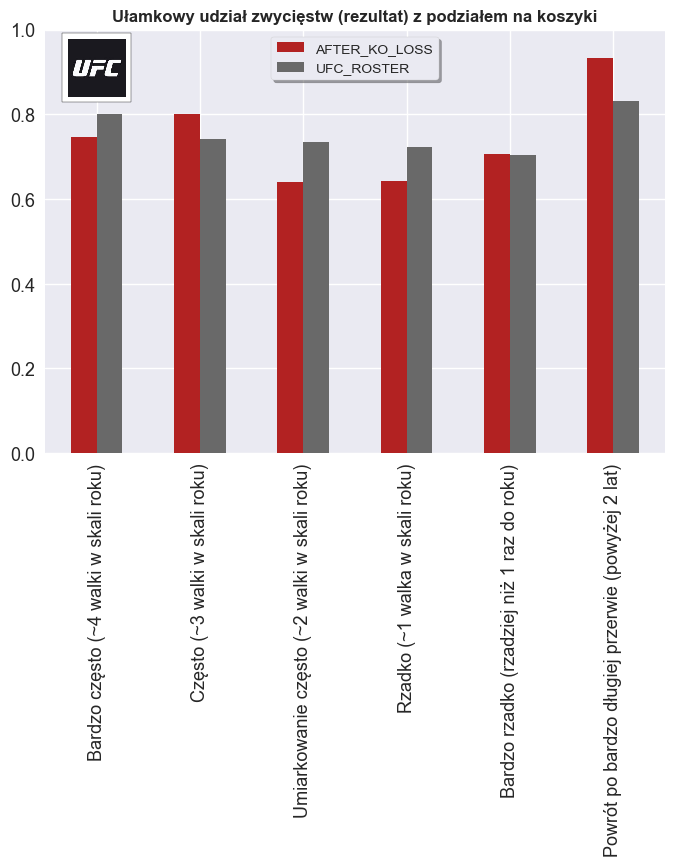

In [578]:
create_occ_barplot(ufc_ako_frame, 'ufc', ['firebrick', 'dimgrey'])

***Analiza nie potwierdziła postawionej tezy dla grupy rostera UFC*** - jak widzimy dla interwałów o charakterystyce: *Bardzo często, Umiarkowanie często oraz Rzadko* osiągany rezultat dla zawodników wracających po porażce przez nokaut był rzeczywiście słabszy niż ogólny wynik rostera UFC. Różnice sięgały niemal *10 punktów procentowych*, jednakże jeden z interwałów o wysokiej częstotliwości 3 walk w skali roku wykazał odwrotną zależność i to zawodnicy wracający po porażce przez nokaut, w obrębie tego koszyka, wygrywali swoje walki częściej niż średnio miało to miejsce dla całego rostera UFC.

Dla koszyka o częstotliwości rzadszej niż 1 walka w roku oba rezultaty się zrównały, a dla zawodników, którzy w poprzedniej walce doznali porażki przez nokaut, a wracają po ponad 2-letniej przerwie, rezultat osiągnął wyższy o niemal *10 punktów procentowych* wynik, aniżeli dla całego rostera UFC.

Analiza rostera UFC nie potwierdziła stawianej tezy. Dla niektórych koszyków liczba obserwacji była naprawdę mała - poniżej 100. Zobaczymy więc, co pokaże podobna analiza, ale obejmująca całą bazę zawodniczą Sherdoga.

In [579]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Tony Galindo,loss,2005-03-20,758,Powrót po bardzo długiej przerwie (powyżej 2 lat)
1,Tony Galindo,loss,2003-02-21,530,Bardzo rzadko (rzadziej niż 1 raz do roku)
2,Tony Galindo,loss,2001-09-09,78,Bardzo często (~4 walki w skali roku)
3,Tony Galindo,win,2001-06-23,119,Często (~3 walki w skali roku)
4,Tony Galindo,draw,2001-02-24,87,Bardzo często (~4 walki w skali roku)
5,Tony Galindo,win,2000-11-29,158,Umiarkowanie często (~2 walki w skali roku)
6,Tony Galindo,win,2000-06-24,0,Debiut/walka stoczona tego samego dnia
7,Kurt Rojo,loss,2000-12-09,168,Umiarkowanie często (~2 walki w skali roku)
8,Kurt Rojo,loss,2000-06-24,0,Debiut/walka stoczona tego samego dnia
9,Brian Hawkins,loss,2006-03-18,1121,Powrót po bardzo długiej przerwie (powyżej 2 lat)


In [580]:
sherdog_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time;
0,Tony Galindo,Tony Lopez,loss,KOTC 49 Soboba,Mar / 20 / 2005,KO (Punches),NaN,1,3:24;
1,Tony Galindo,Joey Villasenor,loss,KOTC 21 Invasion,Feb / 21 / 2003,TKO (Corner Stoppage),Larry Landless,1,5:00;
2,Tony Galindo,Brian Sleeman,loss,GC 6 Caged Beasts,Sep / 09 / 2001,TKO (Corner Stoppage),Larry Landless,2,3:10;
3,Tony Galindo,Reggie Cardiel,win,KOTC 9 Showtime,Jun / 23 / 2001,Decision,NaN,2,5:00;
4,Tony Galindo,Reggie Cardiel,draw,KOTC 7 Wet and Wild,Feb / 24 / 2001,Draw,NaN,2,5:00;
5,Tony Galindo,Brian Hawkins,win,KOTC 6 Road Warriors,Nov / 29 / 2000,TKO (Punches),NaN,1,1:30;
6,Tony Galindo,Kurt Rojo,win,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
7,Kurt Rojo,Phillip Miller,loss,GC 1 Gladiator Challenge 1,Dec / 09 / 2000,Decision,NaN,3,5:00;
8,Kurt Rojo,Tony Galindo,loss,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
9,Brian Hawkins,James Lee,loss,KOTC Drop Zone,Mar / 18 / 2006,Submission (Heel Hook),NaN,1,0:24;


In [581]:
# Tworzymy nową zmienną przechowującą kopię DataFrame'u zawodników bazy zawodniczej Sherdoga.
sherdog_extra_data = sherdog_selected_data.copy()

In [582]:
# Dodajemy dwie dodatkowe kolumny, które będą nam konieczne do przeprowadzenia tej i kolejnej analizy.
sherdog_extra_data['Method'] = sherdog_data['Method']
sherdog_extra_data['Round'] = sherdog_data['Round']

In [583]:
sherdog_extra_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Powrót po bardzo długiej przerwie (powyżej 2 lat),KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Corner Stoppage),1
2,Tony Galindo,loss,2001-09-09,78,Bardzo często (~4 walki w skali roku),TKO (Corner Stoppage),2
3,Tony Galindo,win,2001-06-23,119,Często (~3 walki w skali roku),Decision,2
4,Tony Galindo,draw,2001-02-24,87,Bardzo często (~4 walki w skali roku),Draw,2
5,Tony Galindo,win,2000-11-29,158,Umiarkowanie często (~2 walki w skali roku),TKO (Punches),1
6,Tony Galindo,win,2000-06-24,0,Debiut/walka stoczona tego samego dnia,KO (Punch),1
7,Kurt Rojo,loss,2000-12-09,168,Umiarkowanie często (~2 walki w skali roku),Decision,3
8,Kurt Rojo,loss,2000-06-24,0,Debiut/walka stoczona tego samego dnia,KO (Punch),1
9,Brian Hawkins,loss,2006-03-18,1121,Powrót po bardzo długiej przerwie (powyżej 2 lat),Submission (Heel Hook),1


In [584]:
# Użycie maski w celu odsortowania jedynie rekordów, które spełniają warunki analizy i przypisanie wyników nowej zmiennej.
sherdog_after_ko = sherdog_extra_data[(sherdog_extra_data['Result'].shift(-1) == 'loss') & 
                              (sherdog_extra_data['Method'].shift(-1).str.contains('KO')) & 
                              (sherdog_extra_data['Fighter'] == sherdog_extra_data['Fighter'].shift(-1))].copy()

In [585]:
sherdog_after_ko[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Powrót po bardzo długiej przerwie (powyżej 2 lat),KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Corner Stoppage),1
7,Kurt Rojo,loss,2000-12-09,168,Umiarkowanie często (~2 walki w skali roku),Decision,3
9,Brian Hawkins,loss,2006-03-18,1121,Powrót po bardzo długiej przerwie (powyżej 2 lat),Submission (Heel Hook),1
13,Brian Hawkins,win,2002-05-17,56,Bardzo często (~4 walki w skali roku),KO,1
14,Brian Hawkins,loss,2002-03-22,478,Bardzo rzadko (rzadziej niż 1 raz do roku),KO (Punches),1
18,Ken Shamrock,loss,2016-02-19,245,Rzadko (~1 walka w skali roku),TKO (Knee and Punches),1
19,Ken Shamrock,loss,2015-06-19,1667,Powrót po bardzo długiej przerwie (powyżej 2 lat),TKO (Punches),1
21,Ken Shamrock,win,2010-10-16,90,Bardzo często (~4 walki w skali roku),Decision (Unanimous),3
23,Ken Shamrock,win,2009-02-13,342,Rzadko (~1 walka w skali roku),Submission (Armbar),1


In [586]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej
sherdog_ko_brackets = sherdog_after_ko['Descriptive_interval']

In [587]:
# Utworzenie zmiennych gdzie przechowywane będą sumaryczne ilości walk dla poszczególnych kryteriów.
sherdog_ako_all_fights_count = sherdog_ko_brackets.value_counts()
sherdog_ako_win_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'win'].value_counts()
sherdog_ako_loss_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'loss'].value_counts()
sherdog_ako_draw_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'draw'].value_counts()
sherdog_ako_nc_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'NC'].value_counts()

In [588]:
sherdog_ako_all_fights_count

Bardzo często (~4 walki w skali roku)                14987
Rzadko (~1 walka w skali roku)                       12064
Umiarkowanie często (~2 walki w skali roku)           8686
Bardzo rzadko (rzadziej niż 1 raz do roku)            6929
Często (~3 walki w skali roku)                        5731
Powrót po bardzo długiej przerwie (powyżej 2 lat)     4518
Debiut/walka stoczona tego samego dnia                 193
Name: Descriptive_interval, dtype: int64

In [589]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
sherdog_after_ko[sherdog_after_ko['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round


In [590]:
# Weryfikacja, czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii.
sherdog_ako_sum_of_brackets = (sherdog_ako_win_fights_count.sum() + sherdog_ako_loss_fights_count.sum() + 
sherdog_ako_draw_fights_count.sum() + sherdog_ako_nc_fights_count.sum())

if sherdog_ako_all_fights_count.sum() == sherdog_ako_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [591]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
sherdog_ako_pct = sherdog_ako_win_fights_count/(sherdog_ako_win_fights_count + sherdog_ako_loss_fights_count)

In [592]:
# Posortowanie wyników w kolejności malejącej.
sherdog_ako_sorted = sherdog_ako_pct.sort_values(ascending=False)

In [593]:
sherdog_ako_sorted

Umiarkowanie często (~2 walki w skali roku)          0.452715
Często (~3 walki w skali roku)                       0.437222
Rzadko (~1 walka w skali roku)                       0.435099
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.423287
Bardzo często (~4 walki w skali roku)                0.396569
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.390277
Debiut/walka stoczona tego samego dnia               0.331606
Name: Descriptive_interval, dtype: float64

In [594]:
# Utworzenie obiektu DataFrame na potrzeby wizualizacji wyników.
sherdog_ako_frame = pd.DataFrame(dict(AFTER_KO_LOSS = sherdog_ako_sorted, SHERDOG_BASE = sherdog_pct_sorted))

In [595]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji
rep2_index = ['Debiut/walka stoczona tego samego dnia', 'Bardzo często (~4 walki w skali roku)', 
             'Często (~3 walki w skali roku)', 'Umiarkowanie często (~2 walki w skali roku)', 
             'Rzadko (~1 walka w skali roku)', 'Bardzo rzadko (rzadziej niż 1 raz do roku)', 
             'Powrót po bardzo długiej przerwie (powyżej 2 lat)']

sherdog_ako_frame = sherdog_ako_frame.reindex(index=rep2_index)

In [596]:
sherdog_ako_frame

,AFTER_KO_LOSS,SHERDOG_BASE
Debiut/walka stoczona tego samego dnia,0.331606,0.424212
Bardzo często (~4 walki w skali roku),0.396569,0.539734
Często (~3 walki w skali roku),0.437222,0.553287
Umiarkowanie często (~2 walki w skali roku),0.452715,0.542192
Rzadko (~1 walka w skali roku),0.435099,0.521535
Bardzo rzadko (rzadziej niż 1 raz do roku),0.423287,0.490557
Powrót po bardzo długiej przerwie (powyżej 2 lat),0.390277,0.454122


<Figure size 1800x900 with 0 Axes>

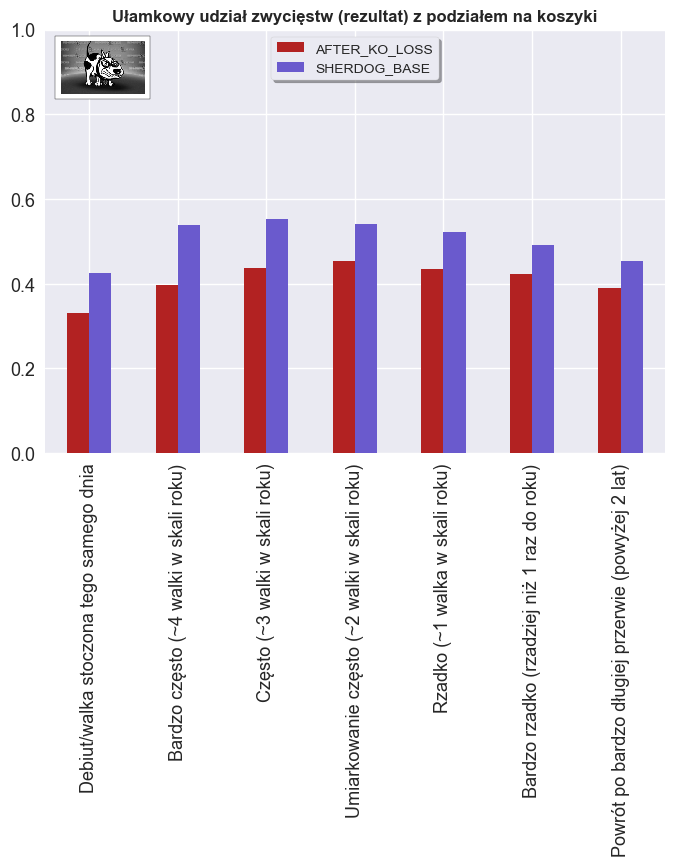

In [597]:
create_occ_barplot(sherdog_ako_frame, 'sherdog', ['firebrick', 'slateblue'])

Analiza całej bazy zawodniczej Sherdoga daje interesujące rezultaty. **Pierwszą zaobserwowaną zależnością jest silna negatywna korelacja pomiędzy powrotem po porażce przez nokaut a szansą na odniesienie zwycięstwa w kolejnej walce.** Dla każdego z koszyków rezultat jest niższy, jeśli zawodnik swoją poprzednią walkę przegrał przez nokaut. Jest to obserwacja, która pokrywa się z intuicją - jeśli zawodnik przegrał przez nokaut, to automatycznie dajemy mu mniejsze szanse na zwycięstwo w kolejnej walce.

Przyglądając się poszczególnym koszykom, widzimy również, że dysproporcja między szansą na odniesienie zwycięstwa dla zawodników wracających po porażce przez nokaut a zawodnikami z danego koszyka maleje wraz ze spadkiem częstotliwości interwału. 
Jeśli zawodnik przegrał swoją poprzednią walkę przez nokaut i wraca do walki po niespełna 90 dniach, to jego szansa względem średniej szansy dla tego interwału jest znacząco niższa (około *14 punktów procentowych*). Jeśli jednak zawodnik zdecyduje się poczekać około roku, to statystycznie jego szansa jest już niższa tylko o niecałe *10 punktów procentowych*, a jeśli przerwa trwa dłużej niż rok, to jest to niecałe *7 punktów procentowych*. 

**Tendencja mogąca potwierdzić założoną hipotezę dla interwałów czasowych zdecydowanie ma miejsce, jednak różnice w wyrażeniu procentowym między tymi interwałami nie są wystarczające.** Podczas gdy zawodnik w najgorszym razie wracając po mniej niż 90 dniach od ostatniej walki, obniża swoje szanse o *14 punktów procentowych*, to czekając ponad 365 dni, ten współczynnik spada jedynie o *7 punktów procentowych*. Założenia wstępne analizy uwzględniały znaczącą zależność statystyczną na poziomie *10 puntów procentowych* i ten próg nie został osiągnięty dla różnic pomiędzy interwałami.

Przyjrzyjmy się teraz kolejnemu czynnikowi, który potencjalnie mógłby wpłynąć na czas, jaki zawodnik powinien sobie dać na powrót do klatki - przeanalizujmy rezultat dla grupy zawodników, która wraca do walki po stoczonym 5-rundowym pojedynku (wynik tej walki nie będzie istotny z punktu widzenia analizy).

In [598]:
ufc_extra_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Umiarkowanie często (~2 walki w skali roku),TKO (Elbow and Punch),2
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Rzadko (~1 walka w skali roku),TKO (Punches),2
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Rzadko (~1 walka w skali roku),KO (Punches),1
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Bardzo często (~4 walki w skali roku),TKO (Punches),4
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Rzadko (~1 walka w skali roku),Decision (Split),3
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Rzadko (~1 walka w skali roku),TKO (Punches),1
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Rzadko (~1 walka w skali roku),Decision (Unanimous),3
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Bardzo rzadko (rzadziej niż 1 raz do roku),Decision (Unanimous),3


In [599]:
# Użycie maski w celu odsortowania jedynie rekordów, które spełniają warunki analizy i przypisanie wyników nowej zmiennej.
ufc_after_5r = ufc_extra_data[(ufc_extra_data['Round'].shift(-1) == 5) & 
                              (ufc_extra_data['Fighter'] == ufc_extra_data['Fighter'].shift(-1))].copy()

In [600]:
ufc_after_5r[0:20]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
51,Israel Adesanya,win,UFC 243 - Whittaker vs. Adesanya,2019-10-05,175,Umiarkowanie często (~2 walki w skali roku),KO (Punches),2
54,Israel Adesanya,win,UFC 230 - Cormier vs. Lewis,2018-11-03,120,Często (~3 walki w skali roku),TKO (Knees and Punches),1
73,Kevin Aguilar,win,LFA 40 - Aguilar vs. Le,2018-05-25,294,Rzadko (~1 walka w skali roku),KO (Punches),1
75,Kevin Aguilar,win,LFA 4 - Aguilar vs. Jackson,2017-02-17,231,Rzadko (~1 walka w skali roku),KO (Punches),3
218,Jose Aldo,loss,UFC 212 - Aldo vs. Holloway,2017-06-03,329,Rzadko (~1 walka w skali roku),TKO (Punches),3
220,Jose Aldo,loss,UFC 194 - Aldo vs. McGregor,2015-12-12,413,Bardzo rzadko (rzadziej niż 1 raz do roku),KO (Punch),1
221,Jose Aldo,win,UFC 179 - Aldo vs. Mendes 2,2014-10-25,266,Rzadko (~1 walka w skali roku),Decision (Unanimous),5
223,Jose Aldo,win,UFC 163 - Aldo vs. Korean Zombie,2013-08-03,182,Umiarkowanie często (~2 walki w skali roku),TKO (Punches),4
225,Jose Aldo,win,UFC 142 - Aldo vs. Mendes,2012-01-14,98,Często (~3 walki w skali roku),KO (Knee),1
226,Jose Aldo,win,UFC 136 - Edgar vs. Maynard 3,2011-10-08,161,Umiarkowanie często (~2 walki w skali roku),Decision (Unanimous),5


In [601]:
len(ufc_after_5r)

395

In [602]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej
ufc_5r_brackets = ufc_after_5r['Descriptive_interval']

In [603]:
# Utworzenie zmiennych gdzie przechowywana będzie sumaryczna ilość walk dla poszczególnych kryteriów.
ufc_5r_all_fights_count = ufc_5r_brackets.value_counts()
ufc_5r_win_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'win'].value_counts()
ufc_5r_loss_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'loss'].value_counts()
ufc_5r_draw_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'draw'].value_counts()
ufc_5r_nc_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'NC'].value_counts()

In [604]:
ufc_5r_all_fights_count

Umiarkowanie często (~2 walki w skali roku)          140
Rzadko (~1 walka w skali roku)                       131
Często (~3 walki w skali roku)                        48
Bardzo często (~4 walki w skali roku)                 40
Bardzo rzadko (rzadziej niż 1 raz do roku)            33
Powrót po bardzo długiej przerwie (powyżej 2 lat)      3
Debiut/walka stoczona tego samego dnia                 0
Name: Descriptive_interval, dtype: int64

In [605]:
# Sprawdzenie czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
ufc_after_5r[ufc_after_5r['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round


In [606]:
# Weryfikacja, czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii
ufc_5r_sum_of_brackets = ufc_5r_win_fights_count.sum() + ufc_5r_loss_fights_count.sum() + ufc_5r_draw_fights_count.sum() 
+ ufc_5r_nc_fights_count.sum()

if ufc_5r_all_fights_count.sum() == ufc_5r_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

In [607]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
ufc_5r_pct = ufc_5r_win_fights_count/(ufc_5r_win_fights_count + ufc_5r_loss_fights_count)

In [608]:
# Posortowanie wyników w kolejności malejącej.
ufc_5r_sorted = ufc_5r_pct.sort_values(ascending=False)

In [609]:
# Odrzucamy tę kategorię z powodu braku obserwacji.
ufc_5r_sorted = ufc_5r_sorted.drop(labels=['Debiut/walka stoczona tego samego dnia'])

In [610]:
ufc_5r_sorted

Bardzo często (~4 walki w skali roku)                0.825000
Umiarkowanie często (~2 walki w skali roku)          0.737226
Rzadko (~1 walka w skali roku)                       0.726562
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.666667
Często (~3 walki w skali roku)                       0.645833
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.468750
Name: Descriptive_interval, dtype: float64

In [611]:
ufc_pct_trunc

Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.830357
Bardzo często (~4 walki w skali roku)                0.800858
Często (~3 walki w skali roku)                       0.742574
Umiarkowanie często (~2 walki w skali roku)          0.734148
Rzadko (~1 walka w skali roku)                       0.722242
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.703540
Name: Descriptive_interval, dtype: float64

In [612]:
# Utworzenie obiektu DataFrame na potrzeby wizualizacji wyników.
ufc_5r_frame = pd.DataFrame(dict(AFTER_5R_FIGHT = ufc_5r_sorted, UFC_ROSTER = ufc_pct_trunc))

In [613]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji
rep3_index = ['Bardzo często (~4 walki w skali roku)', 'Często (~3 walki w skali roku)', 
             'Umiarkowanie często (~2 walki w skali roku)', 'Rzadko (~1 walka w skali roku)',
             'Bardzo rzadko (rzadziej niż 1 raz do roku)', 'Powrót po bardzo długiej przerwie (powyżej 2 lat)']

ufc_5r_frame = ufc_5r_frame.reindex(index=rep3_index)

In [614]:
ufc_5r_frame

,AFTER_5R_FIGHT,UFC_ROSTER
Bardzo często (~4 walki w skali roku),0.825000,0.800858
Często (~3 walki w skali roku),0.645833,0.742574
Umiarkowanie często (~2 walki w skali roku),0.737226,0.734148
Rzadko (~1 walka w skali roku),0.726562,0.722242
Bardzo rzadko (rzadziej niż 1 raz do roku),0.468750,0.703540
Powrót po bardzo długiej przerwie (powyżej 2 lat),0.666667,0.830357


<Figure size 1800x900 with 0 Axes>

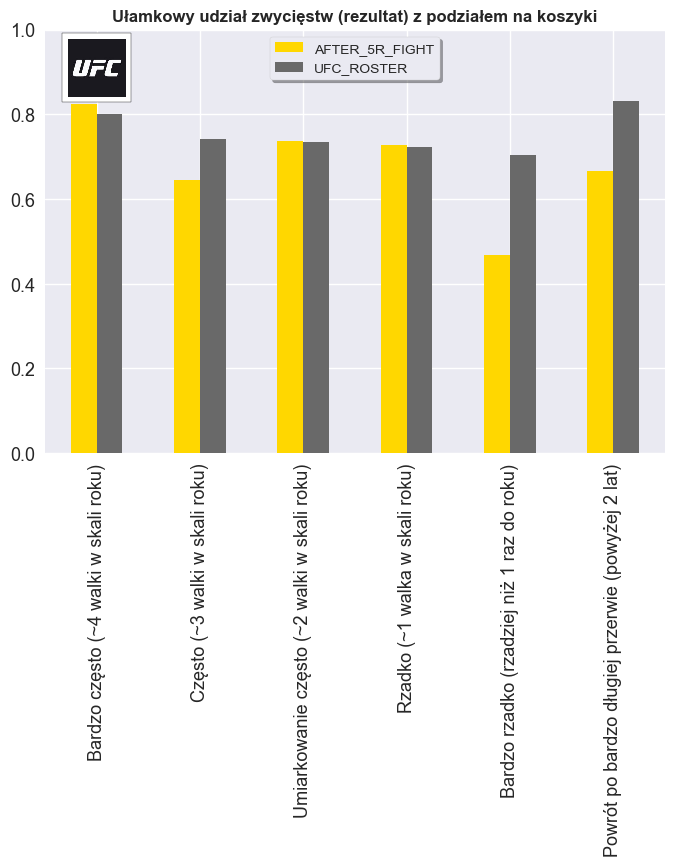

In [615]:
create_occ_barplot(ufc_5r_frame, 'ufc', ['gold','dimgrey'])

Analiza rostera UFC nie wykazała, aby okoliczność przewalczenia 5 rund w poprzedniej walce wpływała w jakikolwiek sposób na rezultat zawodnika w kolejnym boju. Warto mieć tutaj na względzie małą liczbę obserwacji - poniżej 100. Jedynie koszyki odpowiadające częstotliwości 1 i 2 walk w skali roku, miały dostateczną reprezentację. Jak widzimy, właśnie te dwa koszyki nie wykazały praktycznie żadnej różnicy, pomiędzy rezultatem dla całej grupy rostera UFC, a badanej grupy, która swoją poprzednią walkę stoczyła na pełnym dystansie.

Przyjrzyjmy się jeszcze analogicznym danym dla całej bazy zawodniczej Sherdoga.

In [616]:
sherdog_extra_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Powrót po bardzo długiej przerwie (powyżej 2 lat),KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Corner Stoppage),1
2,Tony Galindo,loss,2001-09-09,78,Bardzo często (~4 walki w skali roku),TKO (Corner Stoppage),2
3,Tony Galindo,win,2001-06-23,119,Często (~3 walki w skali roku),Decision,2
4,Tony Galindo,draw,2001-02-24,87,Bardzo często (~4 walki w skali roku),Draw,2
5,Tony Galindo,win,2000-11-29,158,Umiarkowanie często (~2 walki w skali roku),TKO (Punches),1
6,Tony Galindo,win,2000-06-24,0,Debiut/walka stoczona tego samego dnia,KO (Punch),1
7,Kurt Rojo,loss,2000-12-09,168,Umiarkowanie często (~2 walki w skali roku),Decision,3
8,Kurt Rojo,loss,2000-06-24,0,Debiut/walka stoczona tego samego dnia,KO (Punch),1
9,Brian Hawkins,loss,2006-03-18,1121,Powrót po bardzo długiej przerwie (powyżej 2 lat),Submission (Heel Hook),1


In [617]:
# Użycie maski w celu odsortowania jedynie rekordów, które spełniają warunki analizy i przypisanie wyników nowej zmiennej.
sherdog_after_5r = sherdog_extra_data[(sherdog_extra_data['Round'].shift(-1) == 5) & 
                              (sherdog_extra_data['Fighter'] == sherdog_extra_data['Fighter'].shift(-1))].copy()

In [618]:
sherdog_after_5r[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
214,Ricco Rodriguez,loss,2003-02-28,154,Umiarkowanie często (~2 walki w skali roku),TKO (Punches),1
753,Dan Severn,win,2004-11-20,69,Bardzo często (~4 walki w skali roku),TKO (Punches),2
963,Joe Stevenson,win,2016-07-30,547,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Punches),1
1239,Travis Fulton,win,2006-12-15,28,Bardzo często (~4 walki w skali roku),TKO (Submission to Slam),3
2016,Gary Goodridge,win,2002-06-23,174,Umiarkowanie często (~2 walki w skali roku),Decision (Split),3
2318,Tito Ortiz,loss,2004-04-02,189,Rzadko (~1 walka w skali roku),KO (Punches),2
2320,Tito Ortiz,win,2002-11-22,420,Bardzo rzadko (rzadziej niż 1 raz do roku),TKO (Corner Stoppage),3
2324,Tito Ortiz,win,2000-12-16,246,Rzadko (~1 walka w skali roku),Submission (Neck Crank),1
2362,Kevin Randleman,loss,2000-11-17,161,Umiarkowanie często (~2 walki w skali roku),TKO (Strikes),3
2363,Kevin Randleman,win,2000-06-09,203,Rzadko (~1 walka w skali roku),Decision (Unanimous),5


In [619]:
len(sherdog_after_5r)

3152

In [620]:
# Przypisanie wyników kolumny z opisowym interwałem do zmiennej
sherdog_5r_brackets = sherdog_after_5r['Descriptive_interval']

In [621]:
# Utworzenie zmiennych gdzie przechowywana będzie sumaryczna ilość walk dla poszczególnych kryteriów.
sherdog_5r_all_fights_count = sherdog_5r_brackets.value_counts()
sherdog_5r_win_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'win'].value_counts()
sherdog_5r_loss_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'loss'].value_counts()
sherdog_5r_draw_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'draw'].value_counts()
sherdog_5r_nc_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'NC'].value_counts()

In [622]:
sherdog_5r_all_fights_count

Rzadko (~1 walka w skali roku)                       888
Umiarkowanie często (~2 walki w skali roku)          777
Bardzo często (~4 walki w skali roku)                679
Często (~3 walki w skali roku)                       418
Bardzo rzadko (rzadziej niż 1 raz do roku)           296
Powrót po bardzo długiej przerwie (powyżej 2 lat)     84
Debiut/walka stoczona tego samego dnia                10
Name: Descriptive_interval, dtype: int64

In [623]:
# Sprawdzenie, czy nie pojawiły się żadne brakujące rekordy w tabeli z interwałem czasowym.
sherdog_after_5r[sherdog_after_5r['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round


In [624]:
# Weryfikacja, czy suma wszystkich walk zakwalifikowanych do koszyków jest równa sumie wszystkich kategorii
sherdog_5r_sum_of_brackets = (sherdog_5r_win_fights_count.sum() + sherdog_5r_loss_fights_count.sum() + 
sherdog_5r_draw_fights_count.sum() + sherdog_5r_nc_fights_count.sum())

if sherdog_5r_all_fights_count.sum() == sherdog_5r_sum_of_brackets:
    print('Weryfikacja zakończona powodzeniem!')

Weryfikacja zakończona powodzeniem!


In [625]:
# Utworzenie zmiennej przechowującej stosunek zwycięstw, do sumy zwycięstw i porażek (rezultat) z podziałem na koszyki.
sherdog_5r_pct = sherdog_5r_win_fights_count/(sherdog_5r_win_fights_count + sherdog_5r_loss_fights_count)

In [626]:
# Posortowanie wyników w kolejności malejącej.
sherdog_5r_sorted = sherdog_5r_pct.sort_values(ascending=False)

In [627]:
sherdog_5r_sorted

Umiarkowanie często (~2 walki w skali roku)          0.641830
Często (~3 walki w skali roku)                       0.627451
Bardzo często (~4 walki w skali roku)                0.614114
Rzadko (~1 walka w skali roku)                       0.599307
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.547368
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.481481
Debiut/walka stoczona tego samego dnia               0.400000
Name: Descriptive_interval, dtype: float64

In [628]:
sherdog_pct_sorted

Często (~3 walki w skali roku)                       0.553287
Umiarkowanie często (~2 walki w skali roku)          0.542192
Bardzo często (~4 walki w skali roku)                0.539734
Rzadko (~1 walka w skali roku)                       0.521535
Bardzo rzadko (rzadziej niż 1 raz do roku)           0.490557
Powrót po bardzo długiej przerwie (powyżej 2 lat)    0.454122
Debiut/walka stoczona tego samego dnia               0.424212
Name: Descriptive_interval, dtype: float64

In [629]:
# Utworzenie obiektu DataFrame na potrzeby wizualizacji wyników.
sherdog_5r_frame = pd.DataFrame(dict(AFTER_5R_FIGHT = sherdog_5r_sorted, SHERDOG_BASE = sherdog_pct_sorted))

In [630]:
# Reindeksowanie DataFrame'u w celu bardziej przejrzystej wizualizacji
rep4_index = ['Debiut/walka stoczona tego samego dnia', 'Bardzo często (~4 walki w skali roku)', 
             'Często (~3 walki w skali roku)', 'Umiarkowanie często (~2 walki w skali roku)', 
             'Rzadko (~1 walka w skali roku)', 'Bardzo rzadko (rzadziej niż 1 raz do roku)', 
             'Powrót po bardzo długiej przerwie (powyżej 2 lat)']

sherdog_5r_frame = sherdog_5r_frame.reindex(index=rep4_index)

In [631]:
sherdog_5r_frame

,AFTER_5R_FIGHT,SHERDOG_BASE
Debiut/walka stoczona tego samego dnia,0.400000,0.424212
Bardzo często (~4 walki w skali roku),0.614114,0.539734
Często (~3 walki w skali roku),0.627451,0.553287
Umiarkowanie często (~2 walki w skali roku),0.641830,0.542192
Rzadko (~1 walka w skali roku),0.599307,0.521535
Bardzo rzadko (rzadziej niż 1 raz do roku),0.547368,0.490557
Powrót po bardzo długiej przerwie (powyżej 2 lat),0.481481,0.454122


<Figure size 1800x900 with 0 Axes>

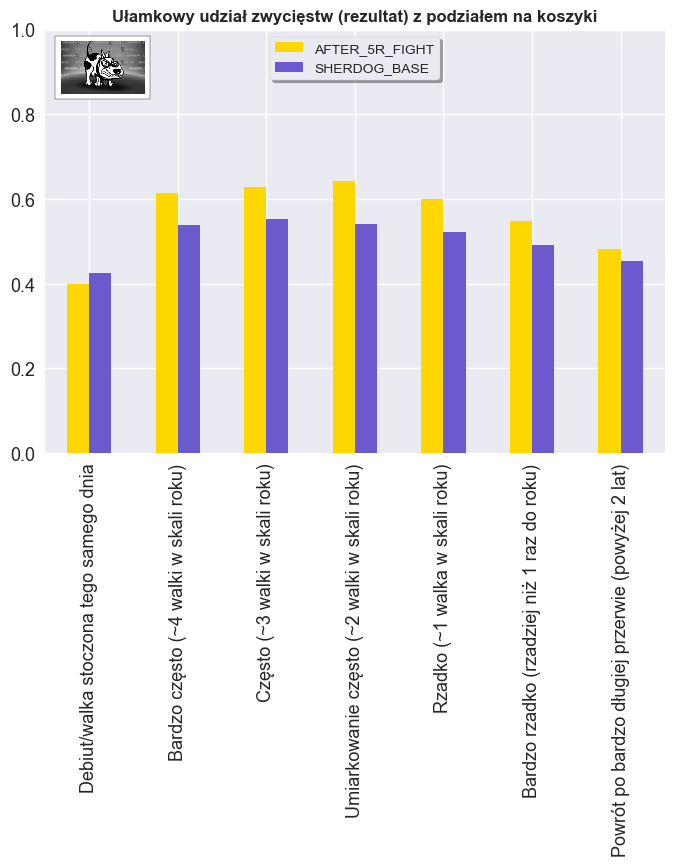

In [632]:
create_occ_barplot(sherdog_5r_frame, 'sherdog', ['gold', 'slateblue'])

Co ciekawe, dla bazy zawodniczej Sherdoga istnieje niewielka (poniżej *10 punktów procentowych*) pozytywna korelacja pomiędzy faktem przewalczenia 5 rund w poprzedniej walce a rezultatem w kolejnej. Ciężko wyjaśnić pochodzenie tej zależności. Pomiędzy interwałami czasowymi nie odnotowano żadnych znaczących różnic, a więc to, jak długo zawodnik, który uprzednio przewalczył 5 rund, musiał czekać do swojej kolejnej walki, nie miało większego wpływu na rezultat który osiągnął. 

## Segment 6: *Podsumowanie, wnioski oraz ciekawostki będące produktem ubocznym niniejszej analizy*

**Analiza wykazała, że istnieje statystycznie znacząca zależność pomiędzy podjęciem walki w przeciągu 91 - 182 dni od ostatniej walki a powrotem po ponad 2-letniej przerwie**, w kontekście osiąganego rezultatu dla całej bazy zawodniczej MMA. Zawodnik wracający do bojów w uwzględnionym powyżej przedziale będzie miał niemal *10 punktów procentowych* większe szanse na pozytywny wynik (odniesienie zwycięstwa), aniżeli zawodnik wracający po ponad 2-letniej przerwie. 
**Powyższa zależność nie została jednak potwierdzona dla populacji elitarnych zawodników MMA będących na kontrakcie z organizacją UFC.**

Zaobserwowano jednocześnie bardzo wyraźną różnicę w osiąganym rezultacie pomiędzy całą grupą zawodniczą bazy Sherdoga a jzawodnikami będącymi jedynie na kontrakcie UFC. Roster UFC wykazał dla każdego interwału czasowego około **20-30 punktów procentowych wyższy rezultat** niż miało to miejsce dla wszystkich zawodników z bazy danych.

**W obrębie walk stoczonych na eventach UFC dominuje częstotliwość od 1 do 2 walk w skali roku** - interwały te osiągnęły największą liczbę obserwacji.
**Analiza wykazała, że dla zawodników UFC walczących na galach UFC, w kontekście osiąganego rezultatu nie ma żadnej różnicy pomiędzy interwałami opisującymi częstotliwość walk od 1 do 3 razy w skali roku**. Ponadto zauważalnie (*niewystarczająco by uznać za statystycznie znaczące*) na rezultat zawodników, negatywnie wpłynęła przerwa skrajnie krótka - do 90 dni oraz dłuższa niż rok, ale nie dłuższa niż 2 lata. Dla obu tych koszyków odnotowano *6-7 punktów procentowych* spadku w rezultacie.

Zarówno dla wszystkich walk zawodników rostera UFC, jak i tylko dla walk w obrębie UFC wykazano zauważalnie niekorzystny wpływ toczenia walk rzadziej niż raz do roku, ale nie rzadziej niż raz na 2 lata.

W przypadku podziału na płeć zaobserwowano, że kobiety w UFC osiągają znacząco lepsze rezultaty, przy niższej częstotliwości walk niż przy wyższej. Optymalnym z punktu widzenia rezultatu przedziałem czasowym pomiędzy walkami dla obu płci w UFC jest przedział **od 121 do 365 dni.** Warto w tym miejscu zwrócić uwagę na zaskakująco dobry rezultat dla zawodników i zawodniczek walczących po ponad 2-letniej przerwie. Szczególnie w przypadku kobiet wynik ten był znacząco lepszy od pozostałych koszyków. Można na tej podstawie spekulować, że fighterzy wracający po tak długiej rozłące z oktagonem dostają relatywnie słabszych rywali/rywalki lub, że pojęcie "rdzy oktagonowej" w rzeczywistości nie istnieje i tak długa przerwa korzystnie wpływa na zdolność zawodnika do wygrania kolejnej walki. Niewykluczone jest również, że oba te czynniki mogą ze sobą koegzystować.

Przyjrzymy się teraz wnioskom charakterystycznym dla poszczególnych kategorii wagowych w UFC:

* W dywizji półciężkiej mężczyzn wysoka częstotliwość walk sprzyja osiąganiu wysokiego rezultatu. Koszyk o częstotliwości walk odpowiadający 4 walkom w skali roku uzyskał o 14 punktów procentowych lepszy rezultat od interwał odpowiadający intensywności 1 walki w skali roku.

* W dywizji średniej mężczyzn zaobserwowano, że najgorzej wypadły koszyki reprezentujące skrajną częstotliwość walk - 4 walki w skali roku oraz rzadziej niż raz do roku. Koszyki te osiągnęły o ponad 10 punktów procentowych gorszy rezultat niż interwał reprezentujący częstotliwość 2 walk w skali roku.

* Dla dywizji lekkiej mężczyzn oraz dla dywizji piórkowej zaobserwowano pozytywny wpływ na osiągany rezultat wraz ze spadkiem częstotliwości walk.

* Dywizję kogucią mężczyzn charakteryzuje skrajnie niski rezultat koszyka o bardzo niskiej częstotliwości (rzadziej niż 1 raz do roku). Koszyk ten osiągnął około 30 punktów procentowych gorszy rezultat od pozostałych.

* W dywizji słomkowej kobiet pozytywnie wyróżnił się interwał o bardzo niskiej częstotliwości - uzyskał on o 10 punktów procentowych lepszy rezultat od pozostałych.

* Dla dywizji muszej kobiet pozytywnie wyróżnił się odstęp czasowy około roku pomiędzy walkami - przy takiej intensywności zawodniczki wygrywały z ponad 10 punktów procentowych większą częstotliwością.

* W dywizji koguciej kobiet najlepsze rezultaty osiągnęły interwały opisujące częstotliwość od 1-2 walk w skali roku. Oba koszyki osiągnęły o 15 punktów procentowych lepszy rezultat niż pozostałe.

Podczas analizy różnych okoliczności, które z założenia mogły mieć wpływ na to, jak długo zawodnik powinien czekać aż do następnej walki, wykazano:

* Silną negatywną korelację pomiędzy powrotem po porażce przez nokaut a szansą na odniesienie zwycięstwa w kolejnej walce dla całej bazy zawodniczej Sherdoga.

* Zaobserwowano tendencję wzrostową dla osiąganego rezultatu zawodników bazy Sherdoga wracających po porażce przez nokaut wraz z wydłużeniem czasu, jaki mieli od ostatniej walki. Pomimo iż tendencja jest niezakłócona, to różnice w ujęciu procentowym pomiędzy nimi nie były wystarczające, aby zakwalifikować je jako statystycznie znaczące.

* Zaobserwowano znaczącą statystycznie, pozytywną zależność pomiędzy osiąganym rezultatem dla zawodników bazy Sherdoga, którzy do walki podchodzili po uprzednio stoczonym pojedynku na dystansie 5 rund. Pomimo tej zależności nie wykazano żadnych różnic dla podziału na interwały czasowe.

* Dla zawodników rostera UFC, w przeciwieństwie do wyników zawodniczej bazy Sherdoga, nie wykazano **żadnej zależności**  pomiędzy okolicznością powrotu po porażce przez nokaut a uzyskanym rezultatem.

* Dla zawodników rostera UFC, w przeciwieństwie do wyników zawodniczej bazy Sherdoga, nie wykazano **żadnej zależności**  pomiędzy okolicznością powrotu po stoczonym na dystansie 5 rund pojedynku a uzyskanym rezultatem.

Ponadto zaobserwowano, że **ponad 80% zawodników aktualnego rostera UFC wygrało swój debiut w MMA.**
Najdłuższą przerwą pomiędzy walkami w historii profesjonalnego MMA może pochwalić się niejaki Mikhail Onufrienko. Wyniosła ona **8730 dni** (24 lata). Dodam, że walka zakończyła się porażką naszego rekordzisty przez nokaut i, o ile nie jest to jakiś błąd w bazie Sherdoga, to aż ciężko uwierzyć, że ktoś zdecydował się na powrót do startów po tak długim czasie.

In [633]:
sherdog_selected_data.loc[sherdog_selected_data['Time_interval'].idxmax()]

Fighter                                                Mikhail Onufrienko
Result                                                               loss
Event_date                                            2019-09-08 00:00:00
Time_interval                                                        8730
Descriptive_interval    Powrót po bardzo długiej przerwie (powyżej 2 lat)
Name: 222877, dtype: object